In [1]:
import os

import pandas as pd
import numpy as np

import networkx as nx

import matplotlib.pyplot as plt

from compute_correlations import compute_pearson_correlation, compute_kendall_correlation
from graphs import build_full_graph, build_threshold_graph, find_max_clique, find_max_independent_set

In [2]:
RESULTS_DIR = 'graph_images'
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

In [3]:
thresholds_by_method = {
    'kendall' : {
        '3h' : 0.5,
        'daily' : 0.5,
        'weekly' : 0.5
    },
    'pearson' : {}
}

thresholds_by_method['pearson']['3h'] = thresholds_by_method['kendall']['3h'] * 0.7559 + 0.3342
thresholds_by_method['pearson']['daily'] = thresholds_by_method['kendall']['daily'] * 0.6544 + 0.4165
thresholds_by_method['pearson']['weekly'] = thresholds_by_method['kendall']['weekly'] * 0.4785 + 0.5610

In [4]:
TITLE_FONT_SIZE = 20
EDGE_LABEL_FONT_SIZE = 12
FIGSIZE = (14, 14)

colors_by_season = {
    'winter' : 'lightblue',
    'spring' : 'pink',
    'autumn' : 'orange',
    'summer' : 'yellowgreen'
}

SEASONS = ['winter', 'spring', 'summer', 'autumn']
season_names_mapping = {
    'winter': 'Зима',
    'spring': 'Весна',
    'summer': 'Лето',
    'autumn': 'Осень'
}

corr_method_names_mapping = {
    "pearson": "Пирсон",
    "kendall": "Кендалл"
}

interval_names_mapping = {
    "3h": "3 часа",
    "daily": "1 день",
    "weekly": "1 неделя"
}

In [5]:
def load_temp_by_season_interval(season, interval):
    cities = ["msk", "spb", "kaz", "ufa", "nn", "novosib", "vlad"]
    df = pd.DataFrame(columns=cities)
    for city in cities:
        df[city] = pd.read_csv(f"result_datasets/{city}_df_{season}_{interval}.csv")["T"]
    city_names_mapping = {
        "msk": "Москва",
        "spb": "Санкт-Петерубрг",
        "kaz": "Казань",
        "ufa": "Уфа",
        "nn": "Н. Новгород",
        "novosib": "Новосибирск", 
        "vlad": "Владивосток"
    }
    df.rename(columns=city_names_mapping, inplace=True)
    return df

In [6]:
def draw_graph_forall_seasons_by_interval(interval, corr_method):
    fig, axs = plt.subplots(2, 2, figsize=FIGSIZE)
    dfs = [load_temp_by_season_interval(season, interval) for season in SEASONS]
    fig.suptitle(
        f"Граф корреляции {corr_method_names_mapping[corr_method]}а ({interval_names_mapping[interval]}, threshold={thresholds_by_method[corr_method][interval]:.02f})",
        fontsize=TITLE_FONT_SIZE, fontweight='bold'
    )
    for i, (df, season) in enumerate(zip(dfs, SEASONS)):
        vertices = df.columns
        edge_weights = compute_pearson_correlation(df) if corr_method == 'pearson' else compute_kendall_correlation(df)
        g = build_threshold_graph(vertices, edge_weights, thresholds_by_method[corr_method][interval])
        pos = nx.circular_layout(g)
        nx.draw(g, pos, ax=axs.flatten()[i], with_labels=True, node_color=colors_by_season[season], font_weight='bold')
        axs.flatten()[i].set_title(f"{season_names_mapping[SEASONS[i]]}", fontsize=20, fontweight='bold')
        edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g, 'weight').items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels, ax=axs.flatten()[i]);
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)
    fig.tight_layout()
    fig.savefig(f"{RESULTS_DIR}/graphs_{corr_method}_{interval}.png", dpi=300)
    
    
def draw_cliques_forall_seasons_by_interval(interval, corr_method):
    fig, axs = plt.subplots(2, 2, figsize=FIGSIZE)
    dfs = [load_temp_by_season_interval(season, interval) for season in SEASONS]
    fig.suptitle(
        f"Максимальная клика (корреляция {corr_method_names_mapping[corr_method]}а, {interval_names_mapping[interval]}, threshold={thresholds_by_method[corr_method][interval]:.02f})",
        fontsize=TITLE_FONT_SIZE, fontweight='bold'
    )
    for i, (df, season) in enumerate(zip(dfs, SEASONS)):
        vertices = df.columns
        edge_weights = compute_pearson_correlation(df) if corr_method == 'pearson' else compute_kendall_correlation(df)
        threshold_graph = build_threshold_graph(vertices, edge_weights, thresholds_by_method[corr_method][interval])
        clique = find_max_clique(threshold_graph)
        pos = nx.circular_layout(clique)
        nx.draw(clique, pos, ax=axs.flatten()[i], with_labels=True, node_color=colors_by_season[season], font_weight='bold')
        axs.flatten()[i].set_title(f"{SEASONS[i]}", fontsize=20, fontweight='bold')
        edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(clique, 'weight').items()}
        nx.draw_networkx_edge_labels(clique, pos, edge_labels, ax=axs.flatten()[i]);
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)
    fig.tight_layout()
    fig.savefig(f"{RESULTS_DIR}/cliques_{corr_method}_{interval}.png", dpi=300)
    
def draw_sets_forall_seasons_by_interval(interval, corr_method):
    fig, axs = plt.subplots(2, 2, figsize=FIGSIZE)
    dfs = [load_temp_by_season_interval(season, interval) for season in SEASONS]
    fig.suptitle(
        f"Максимальное независимое множество (корреляция {corr_method_names_mapping[corr_method]}а, {interval_names_mapping[interval]}, threshold={thresholds_by_method[corr_method][interval]:.02f})",
        fontsize=TITLE_FONT_SIZE, fontweight='bold'
    )
    for i, (df,season) in enumerate(zip(dfs, SEASONS)):
        vertices = df.columns
        edge_weights = compute_pearson_correlation(df) if corr_method == 'pearson' else compute_kendall_correlation(df)
        threshold_graph = build_threshold_graph(vertices, edge_weights, thresholds_by_method[corr_method][interval])
        iset = find_max_independent_set(threshold_graph)
        pos = nx.circular_layout(iset)
        nx.draw(iset, pos, ax=axs.flatten()[i], with_labels=True, node_color=colors_by_season[season], font_weight='bold')
        axs.flatten()[i].set_title(f"{SEASONS[i]}", fontsize=20, fontweight='bold')
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)
    fig.tight_layout()
    fig.savefig(f"{RESULTS_DIR}/sets_{corr_method}_{interval}.png", dpi=300)


# Отрисовка полученных графов и графовых структур

In [7]:
intervals = ["3h", "daily", "weekly"]
methods = ["pearson", "kendall"]

## Отсеченные графы

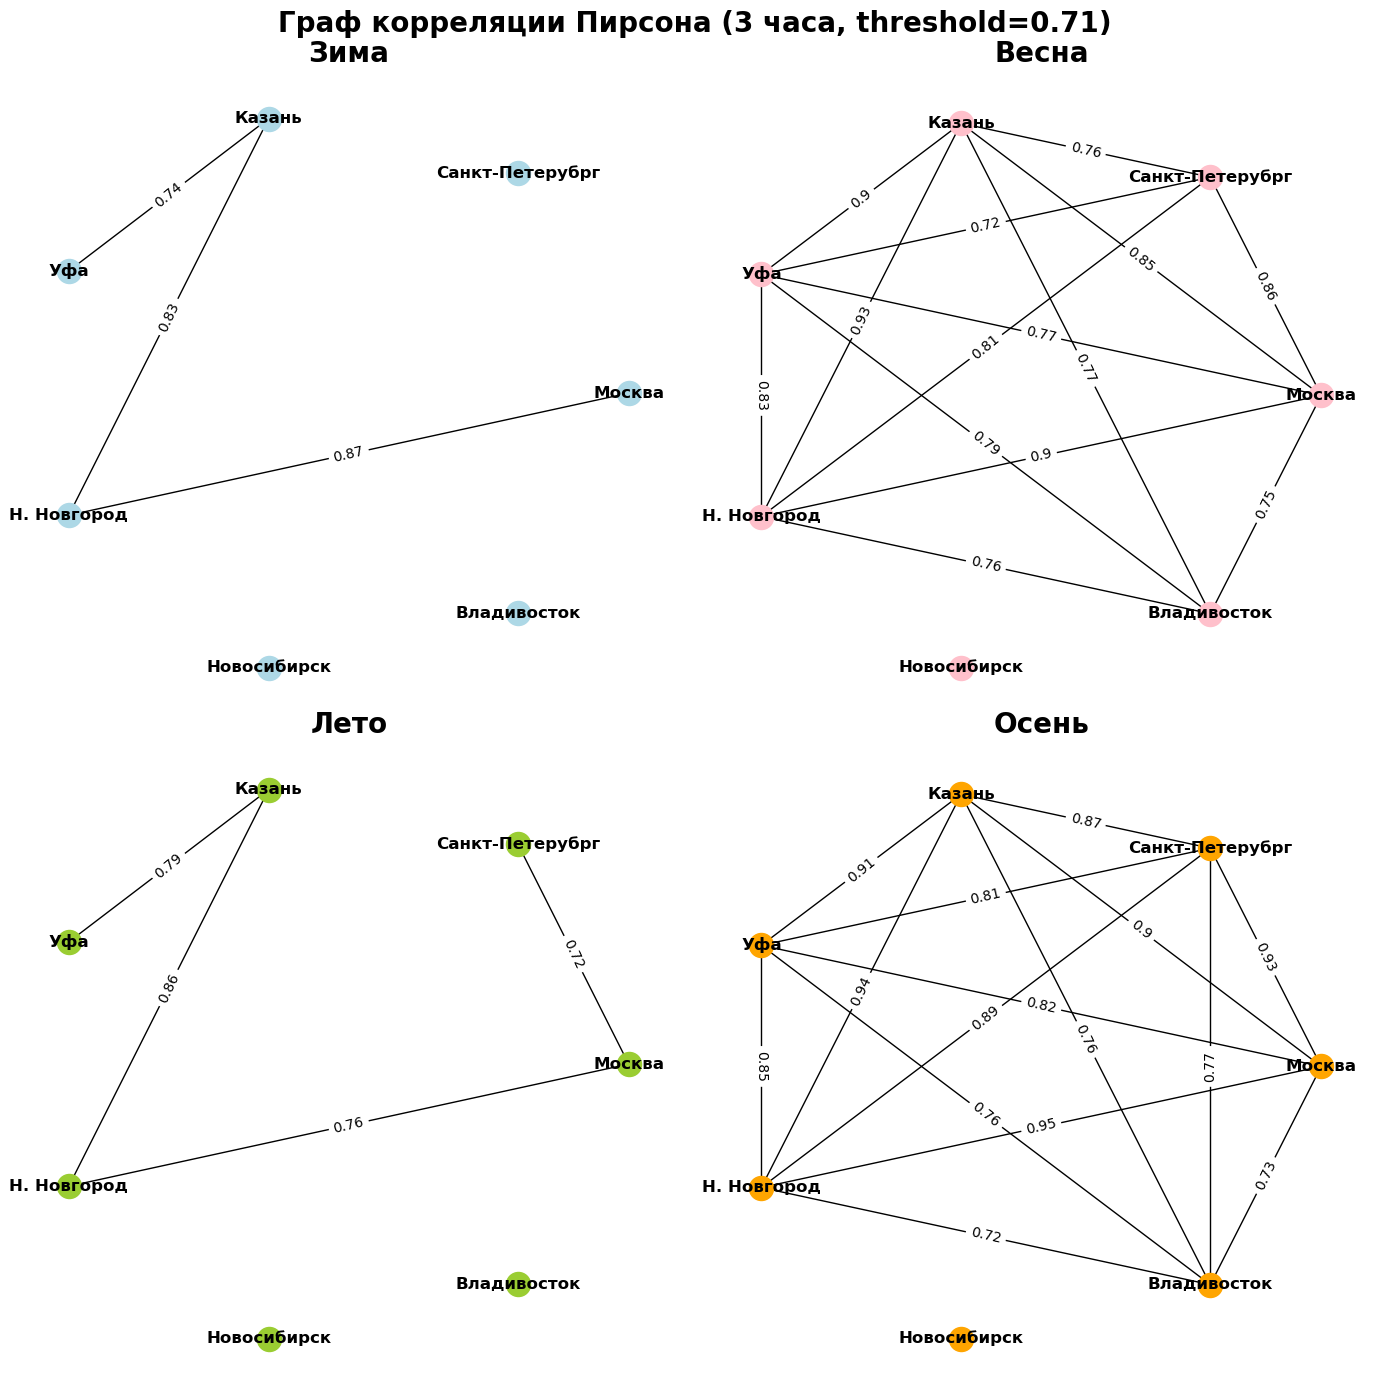

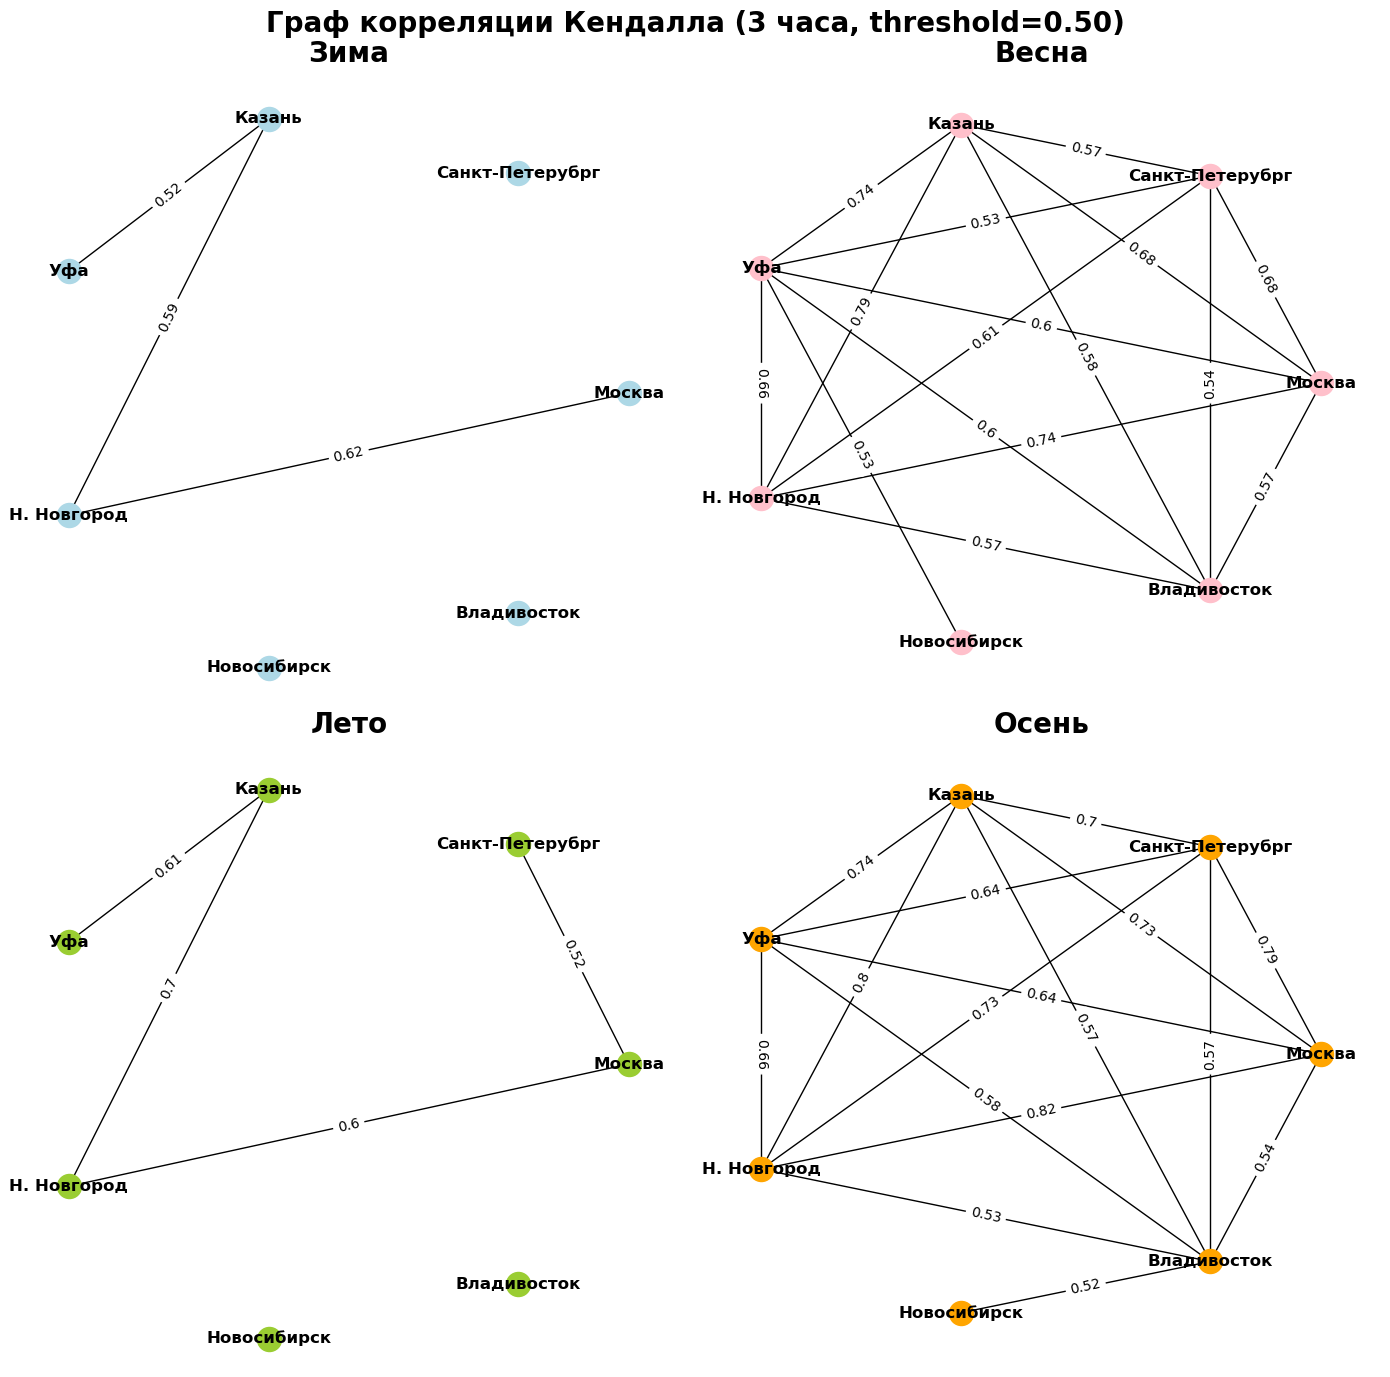

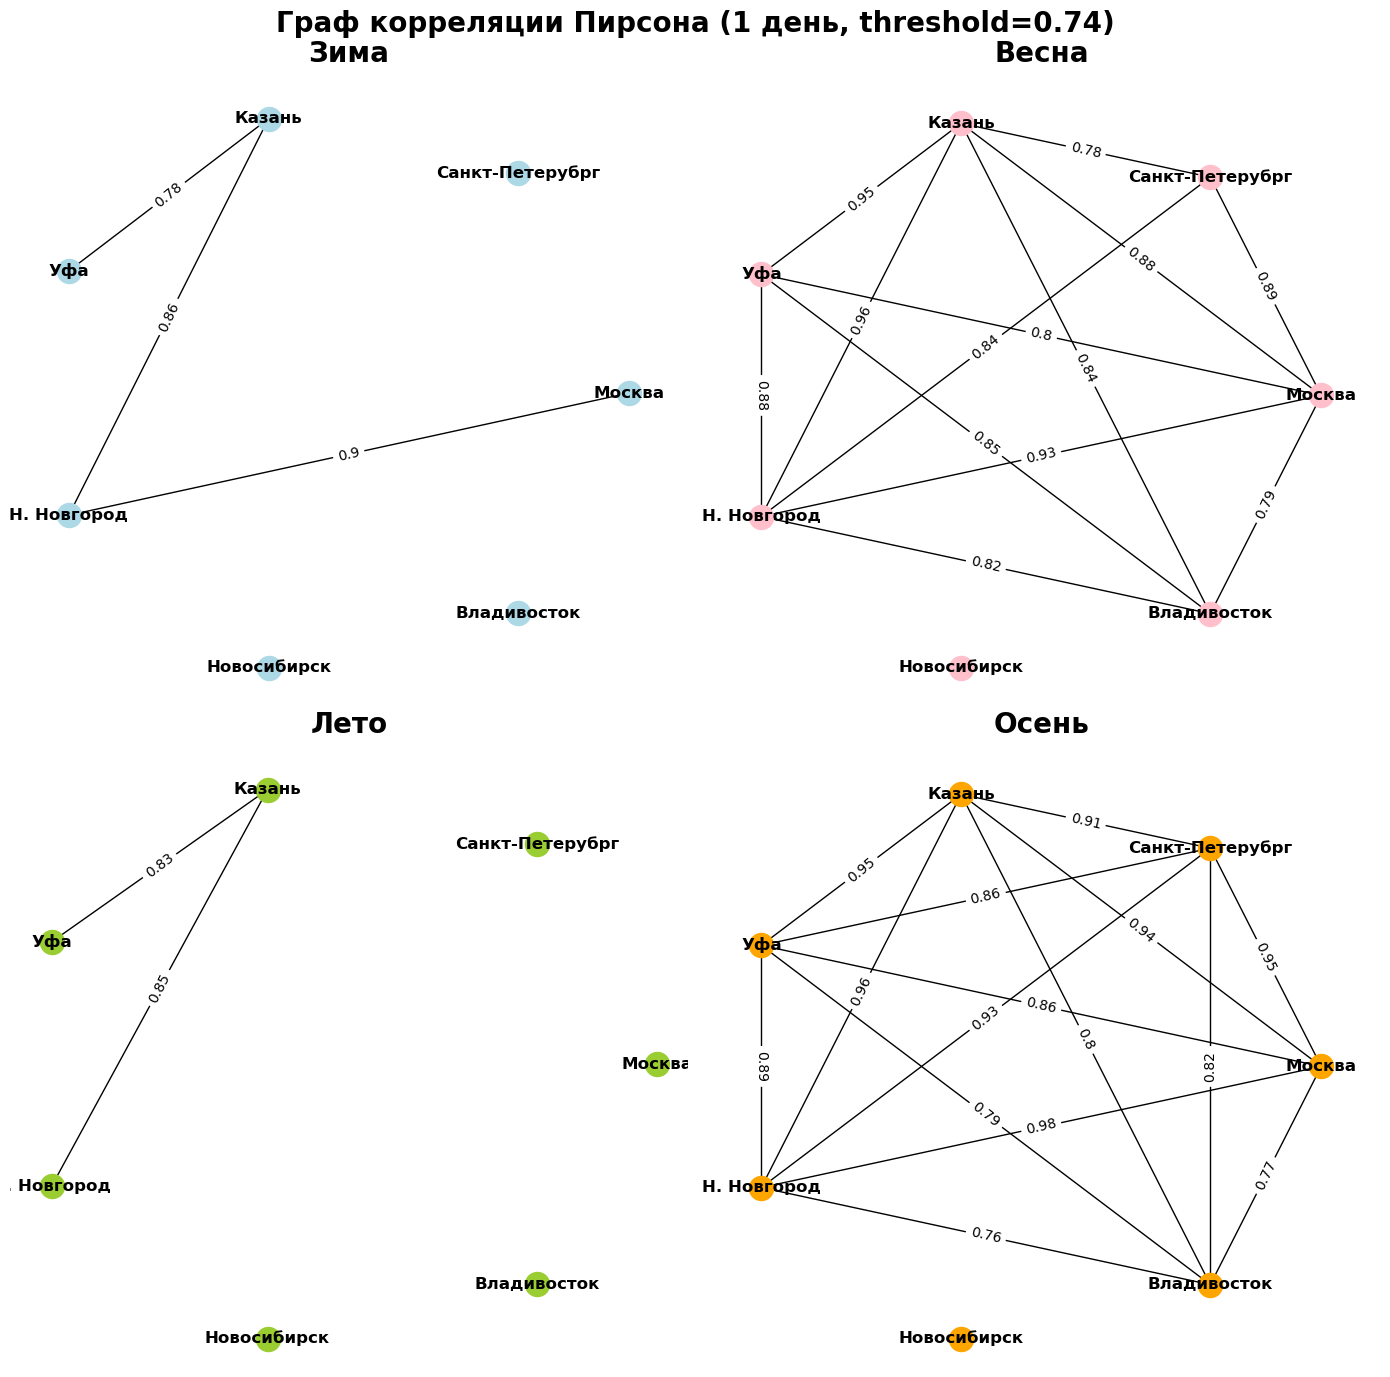

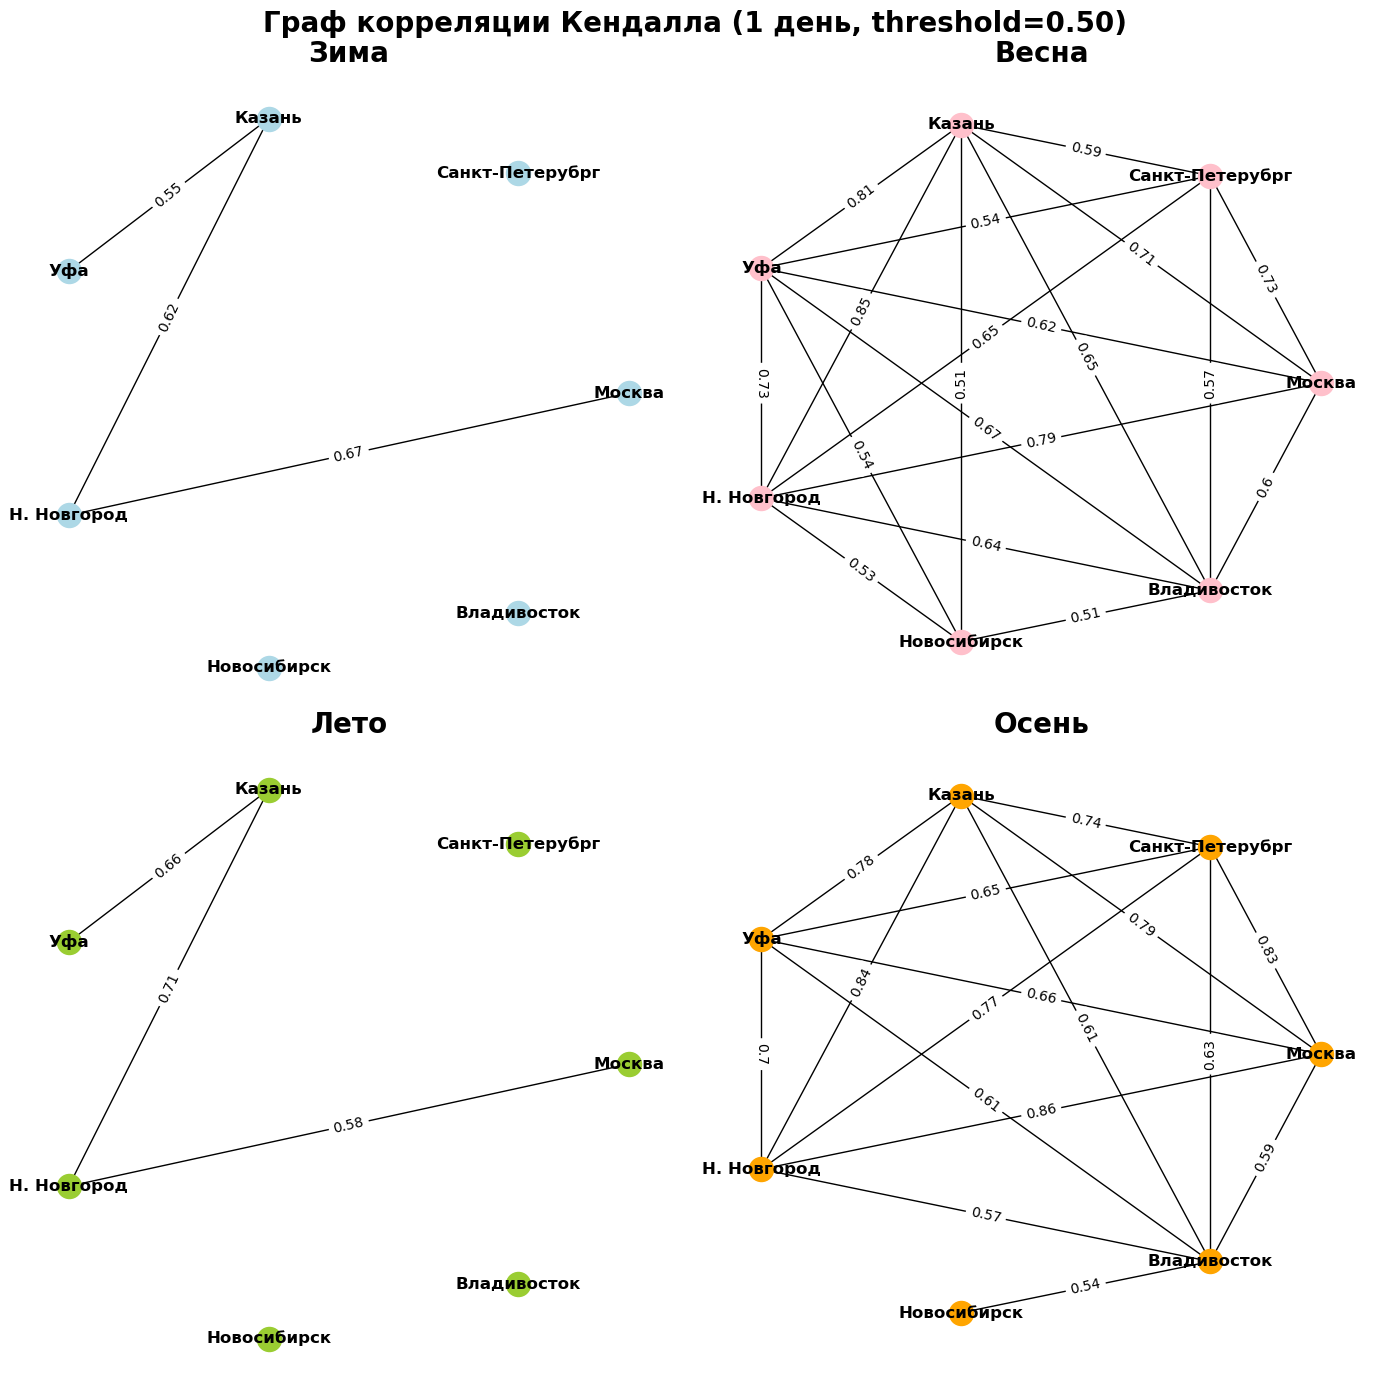

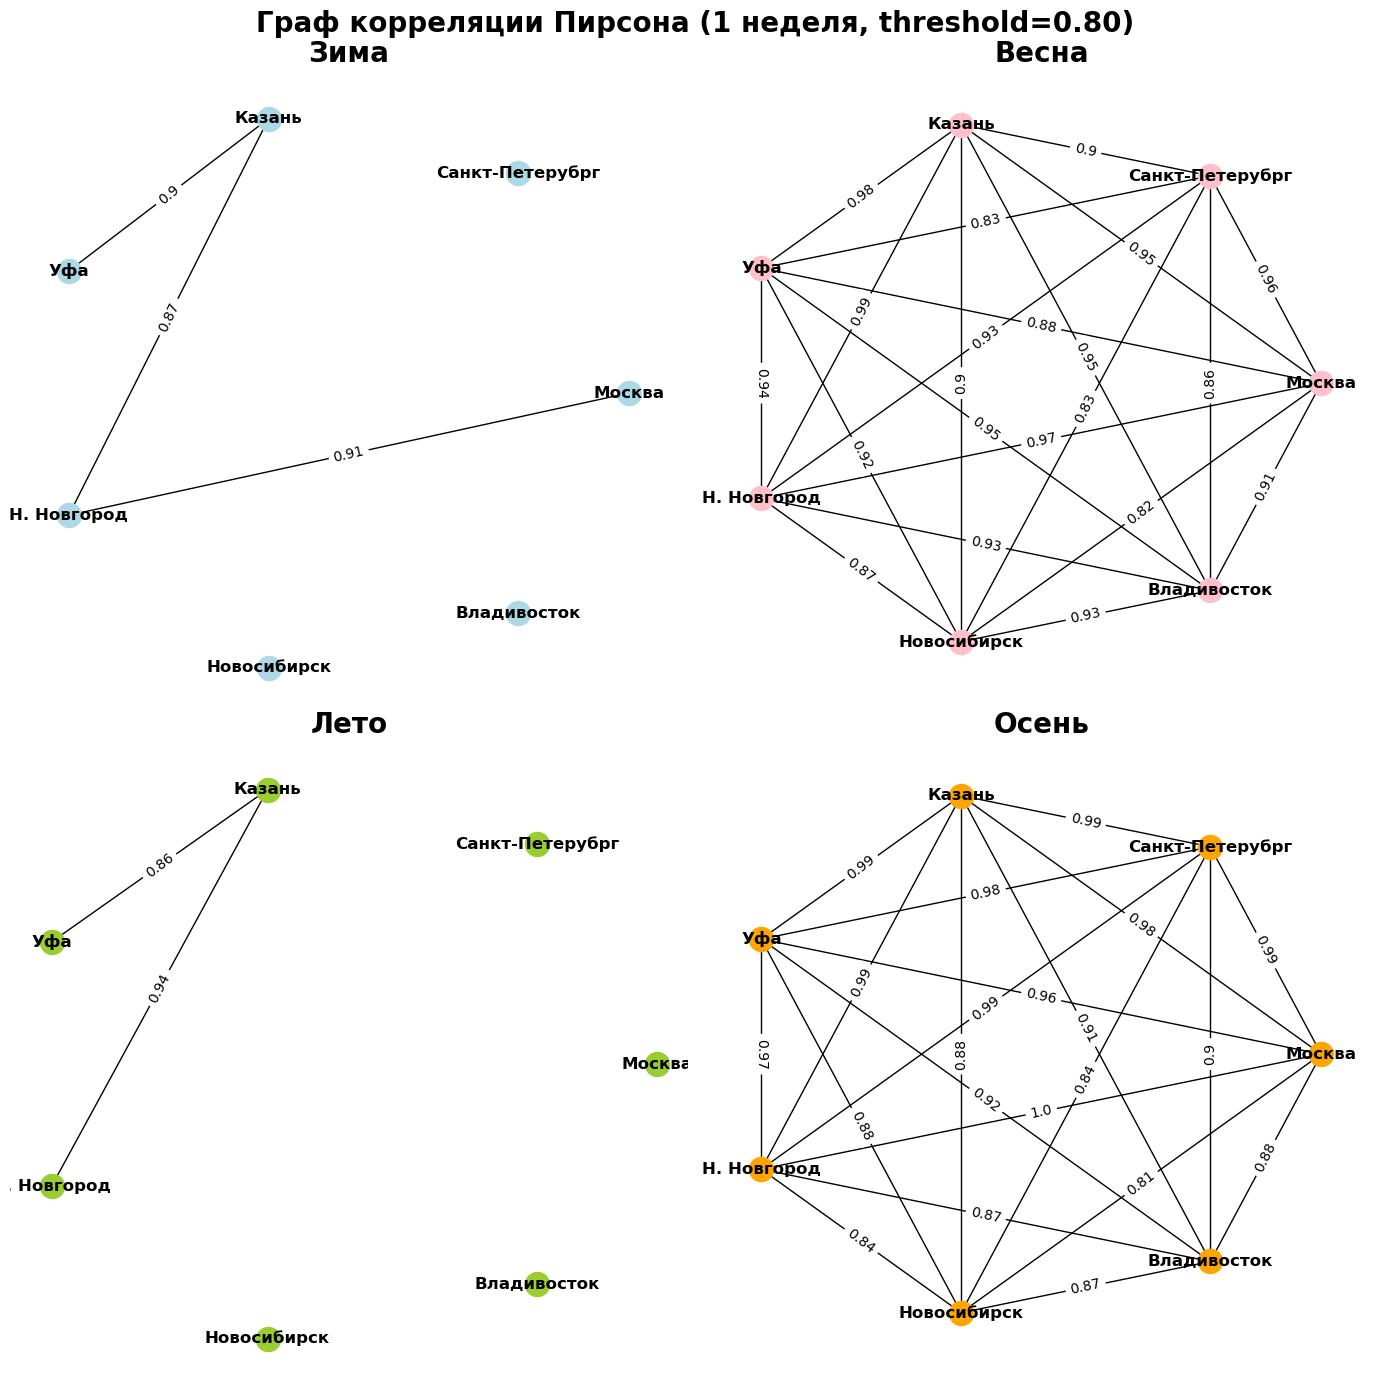

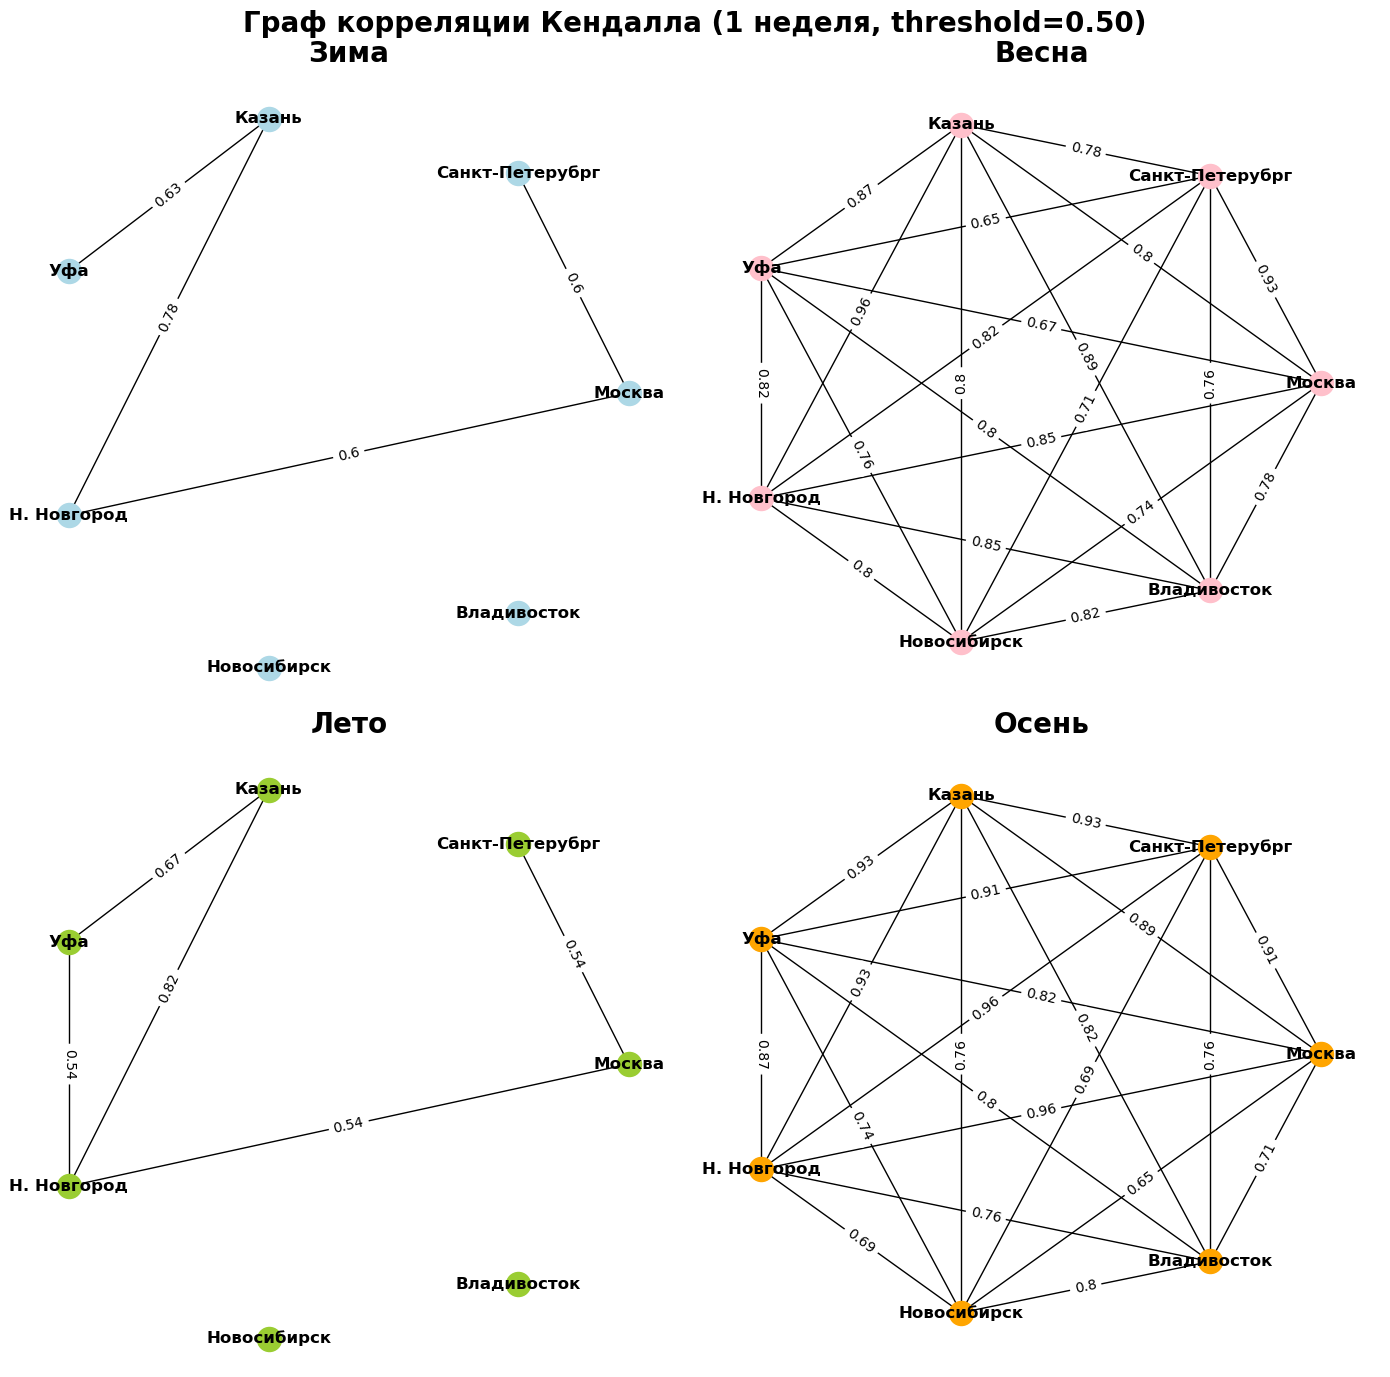

In [8]:
for interval in intervals:
    for corr_method in methods:
        draw_graph_forall_seasons_by_interval(interval, corr_method)

## Клики

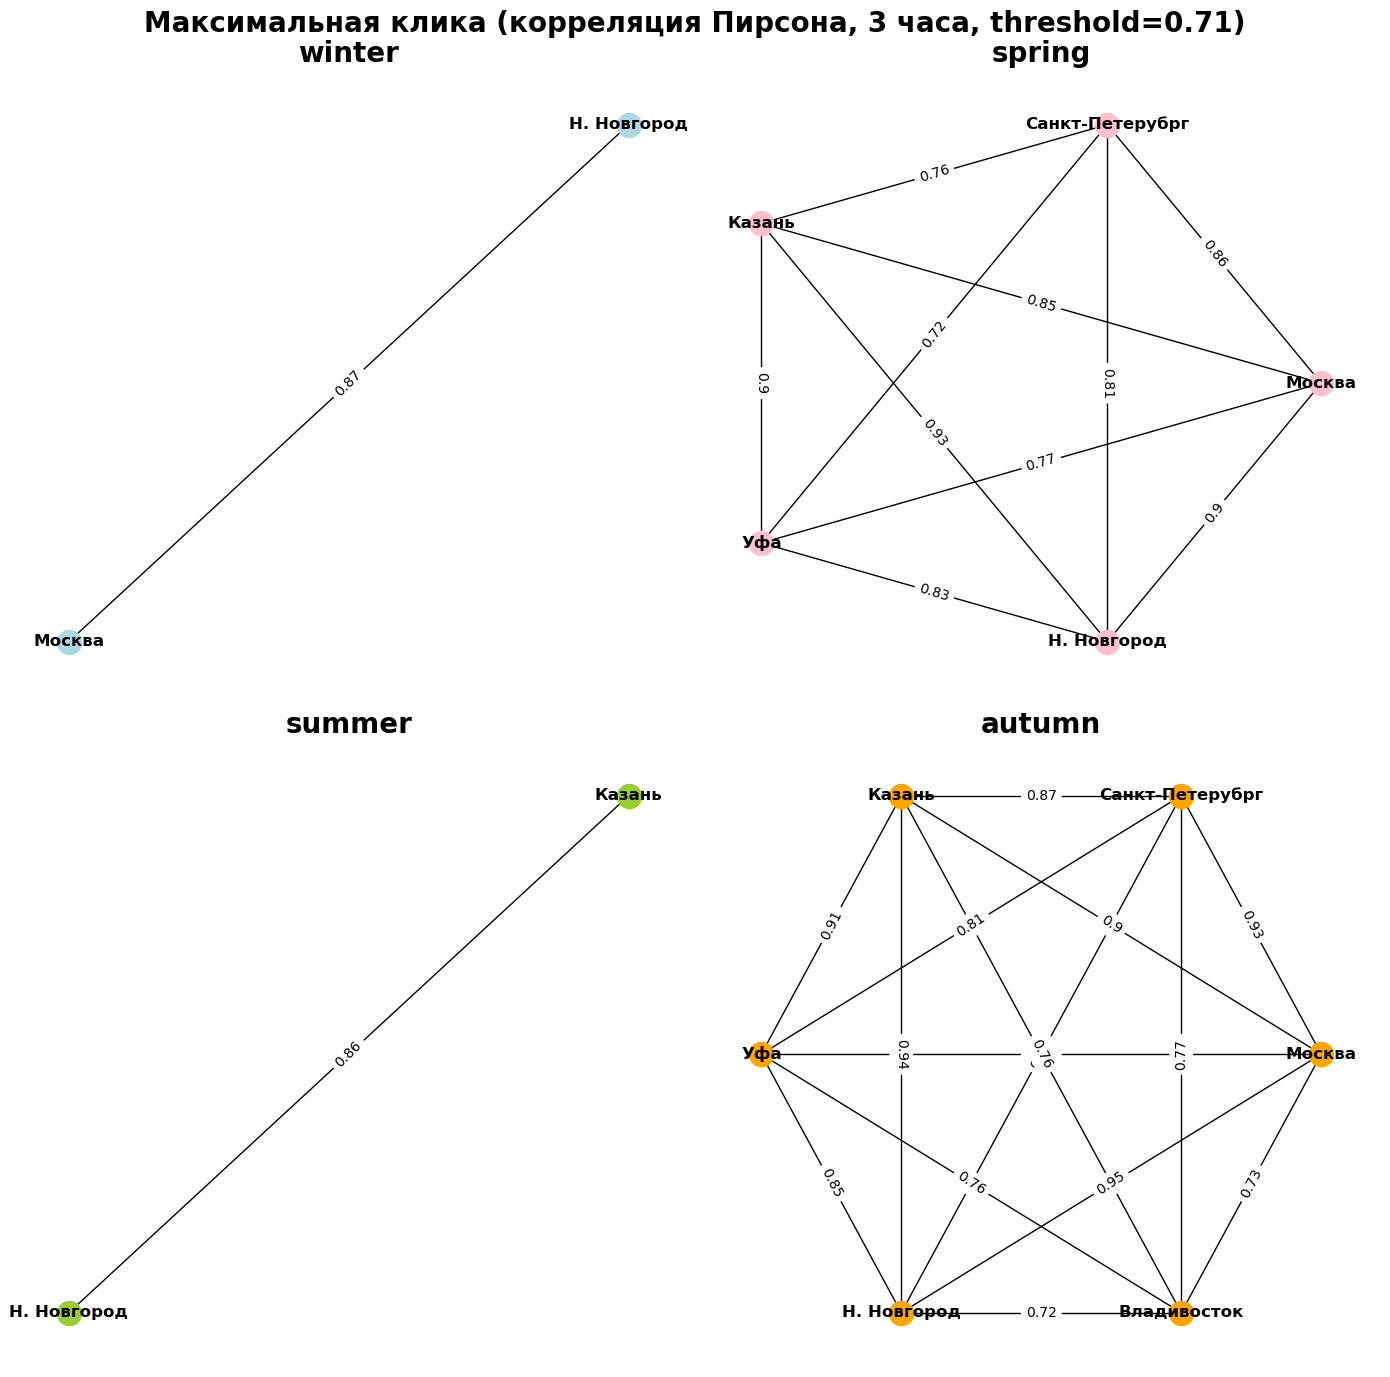

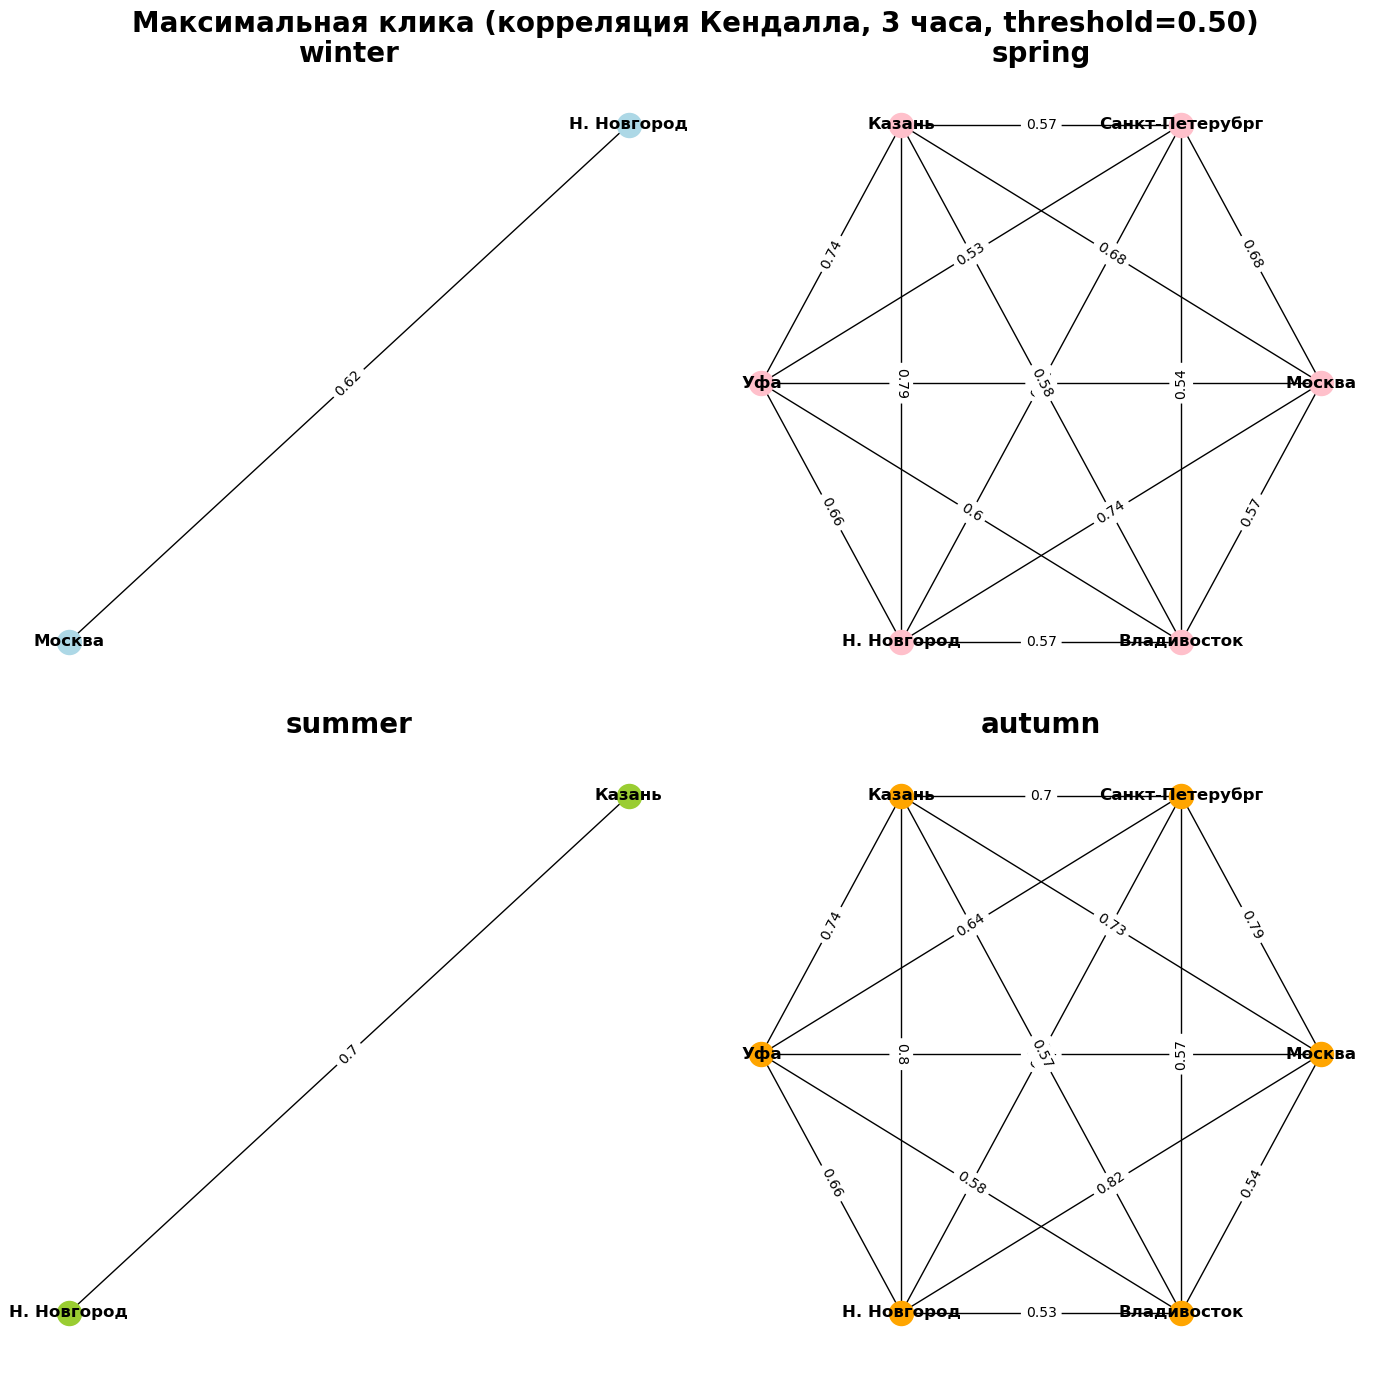

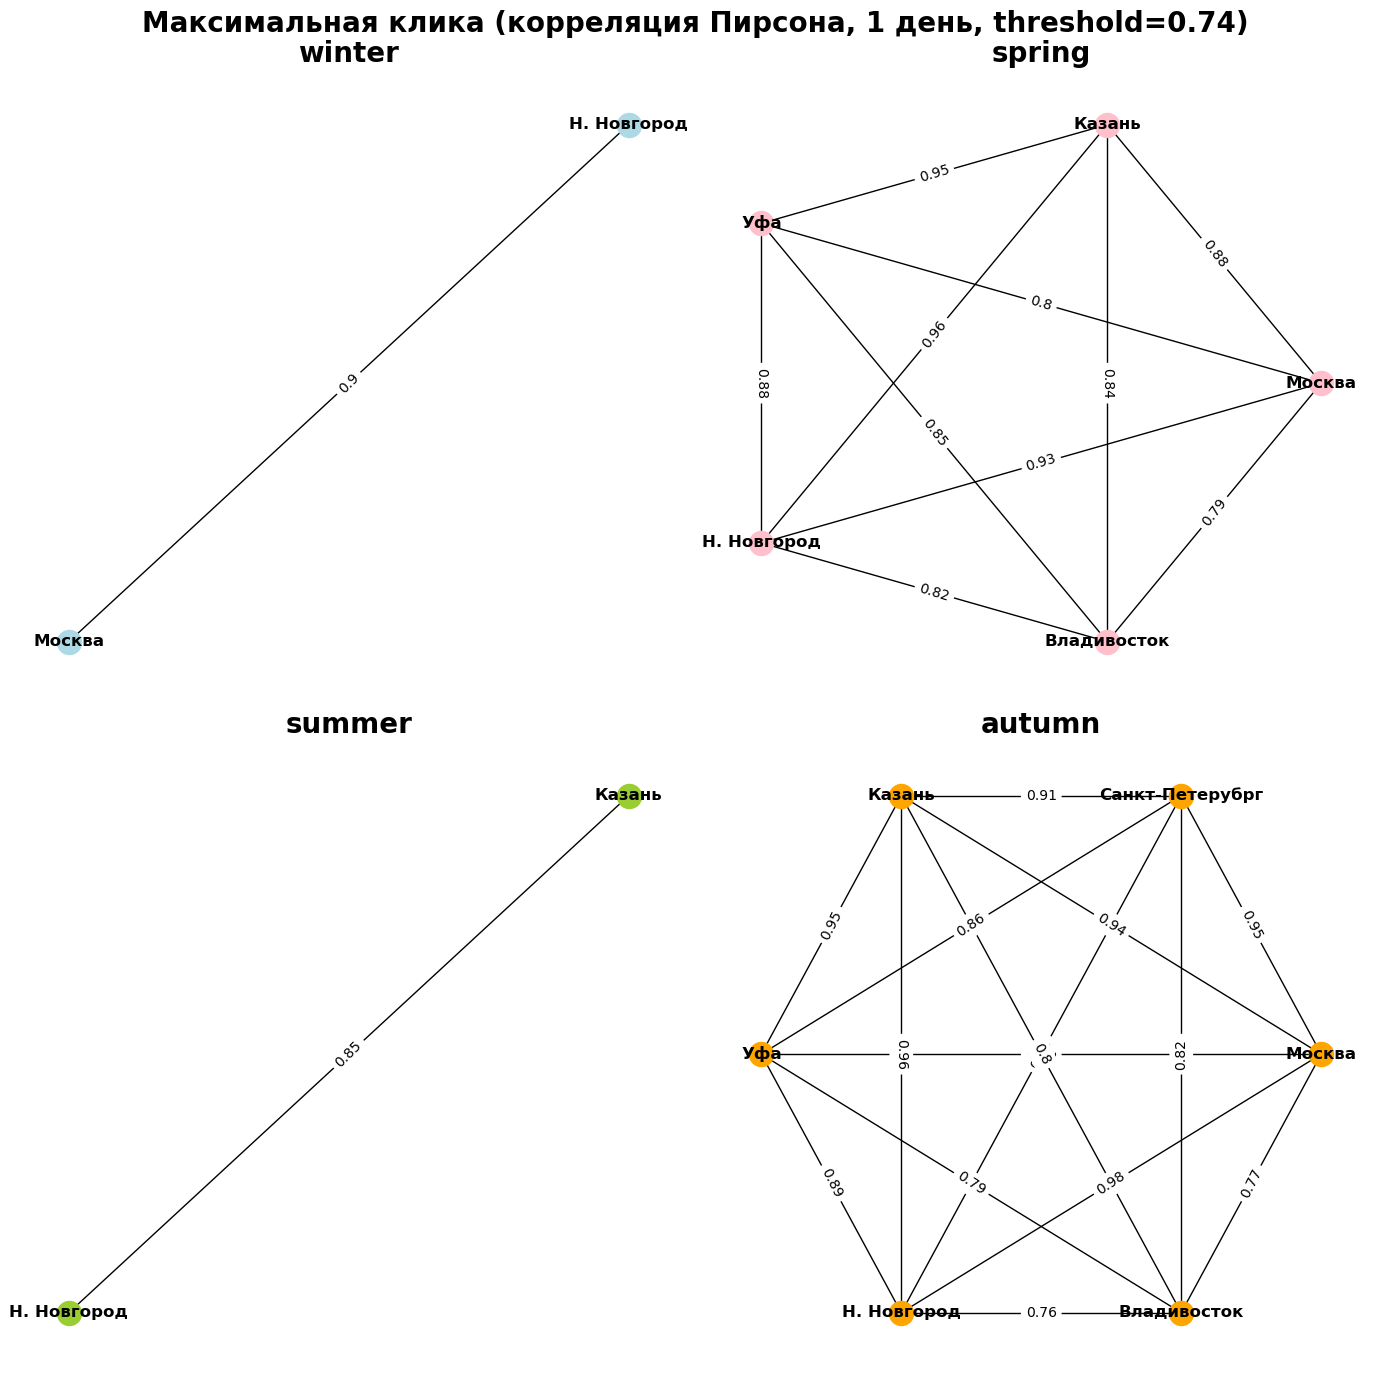

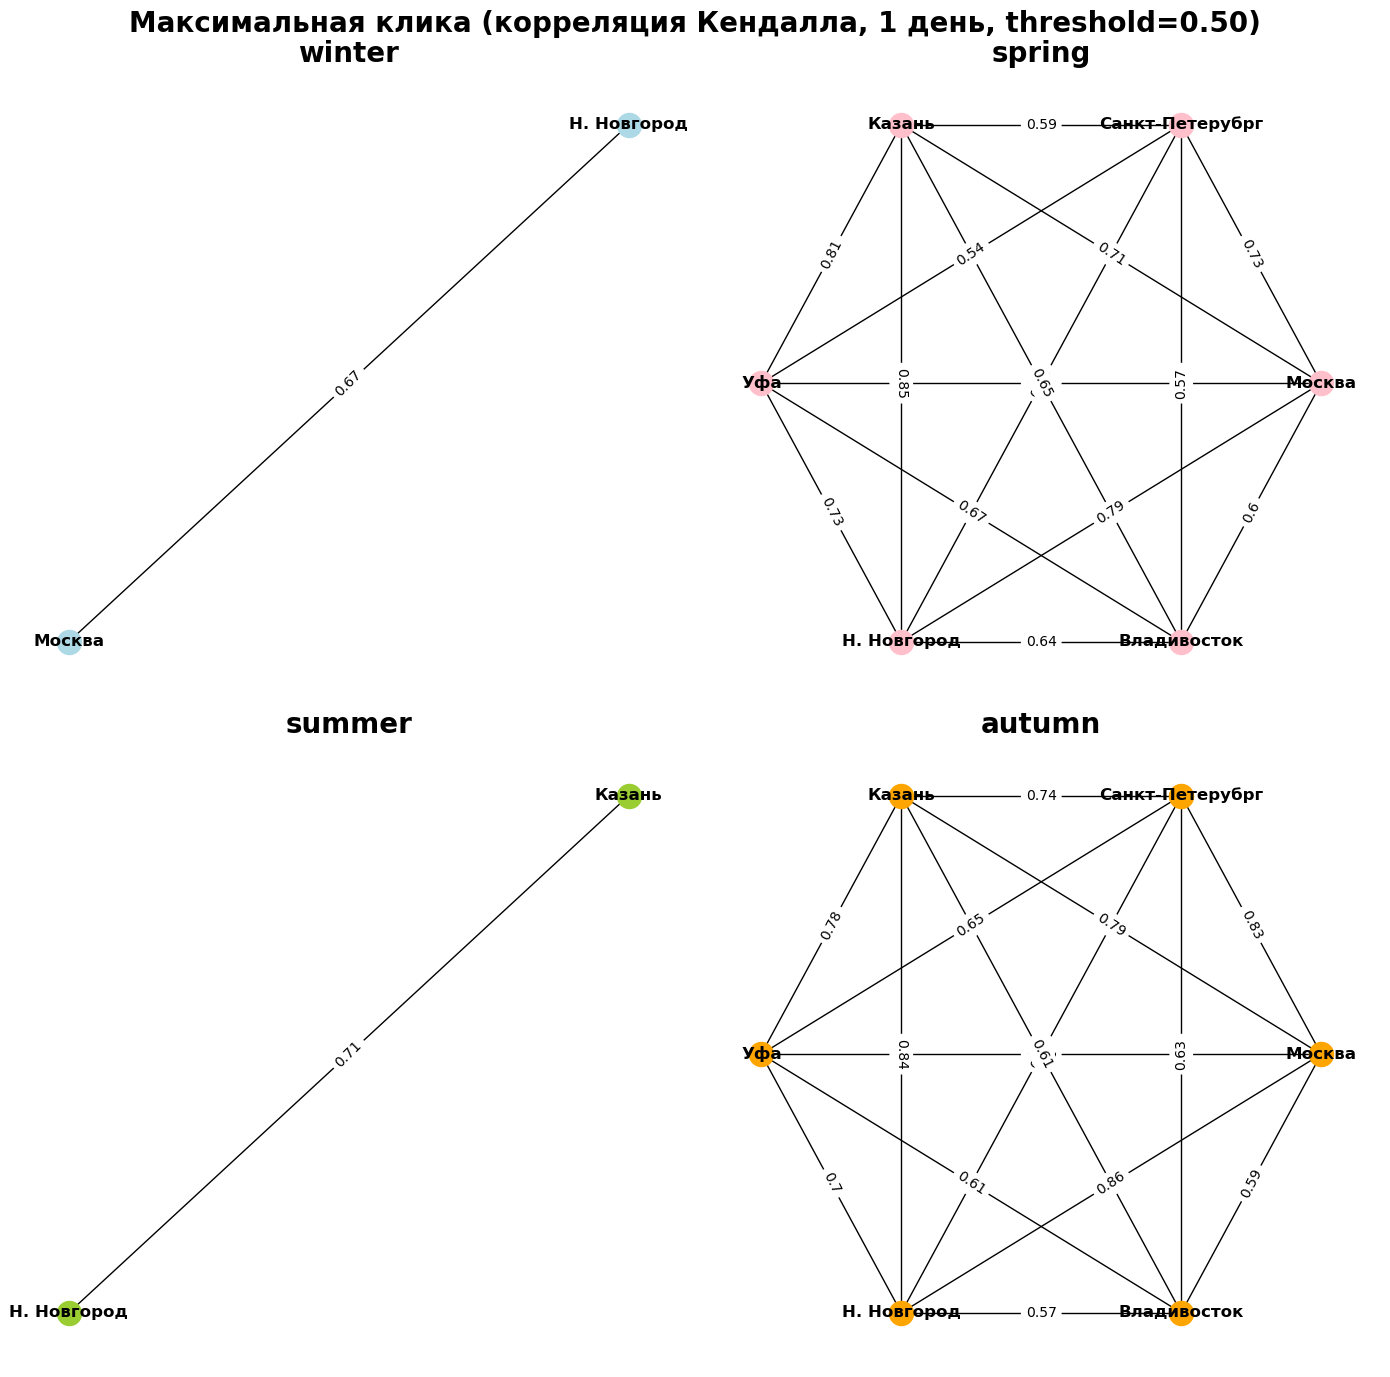

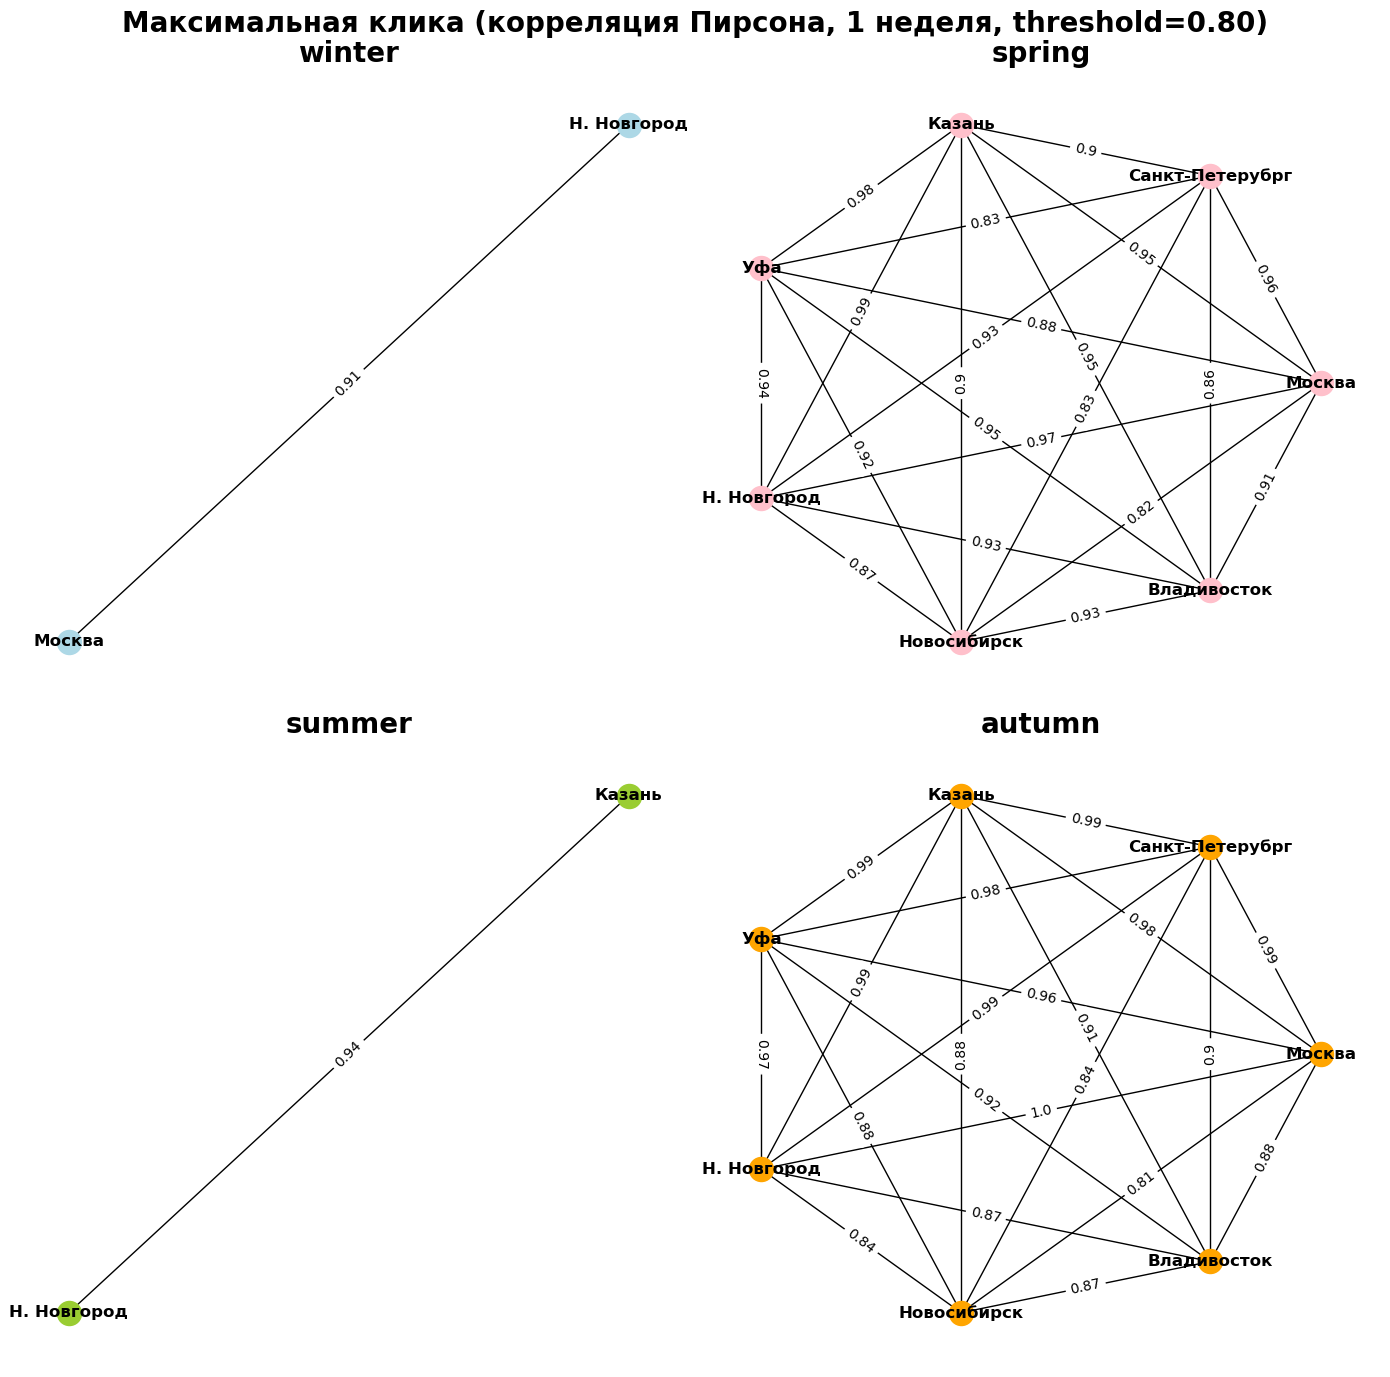

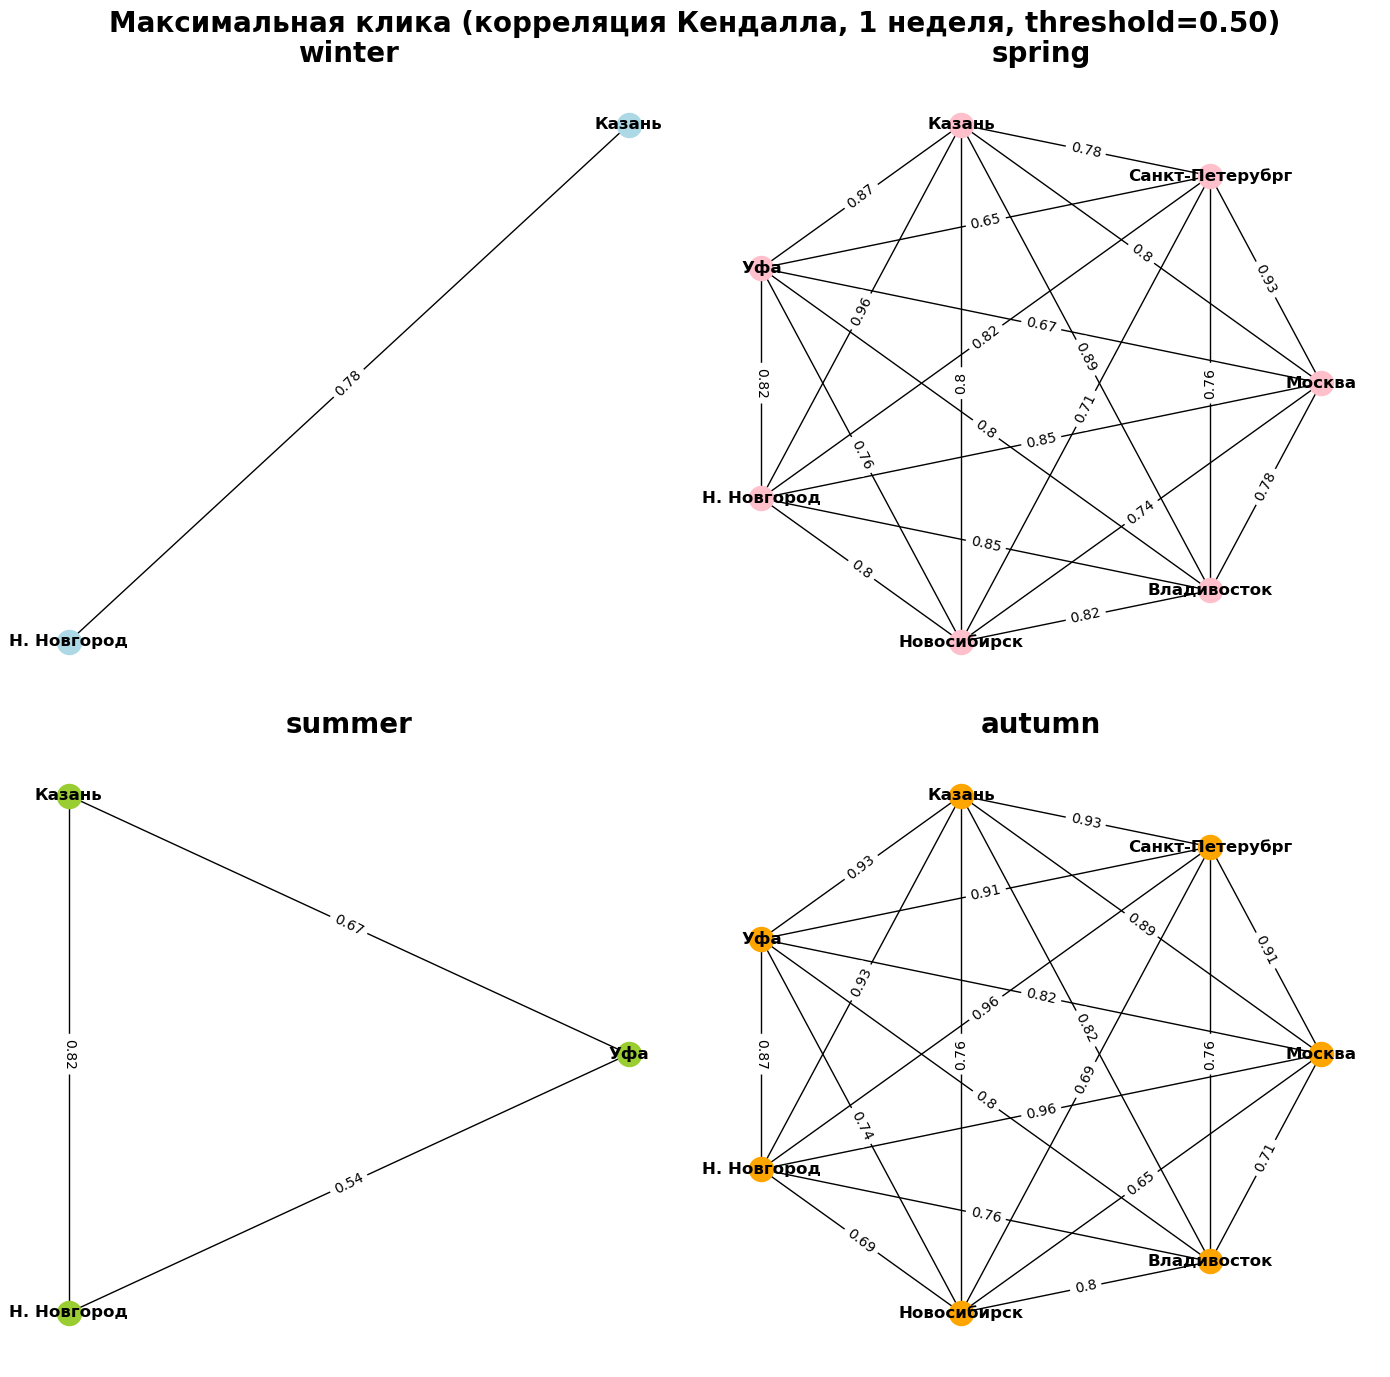

In [9]:
for interval in intervals:
    for corr_method in methods:
        draw_cliques_forall_seasons_by_interval(interval, corr_method)

## Независимые множества

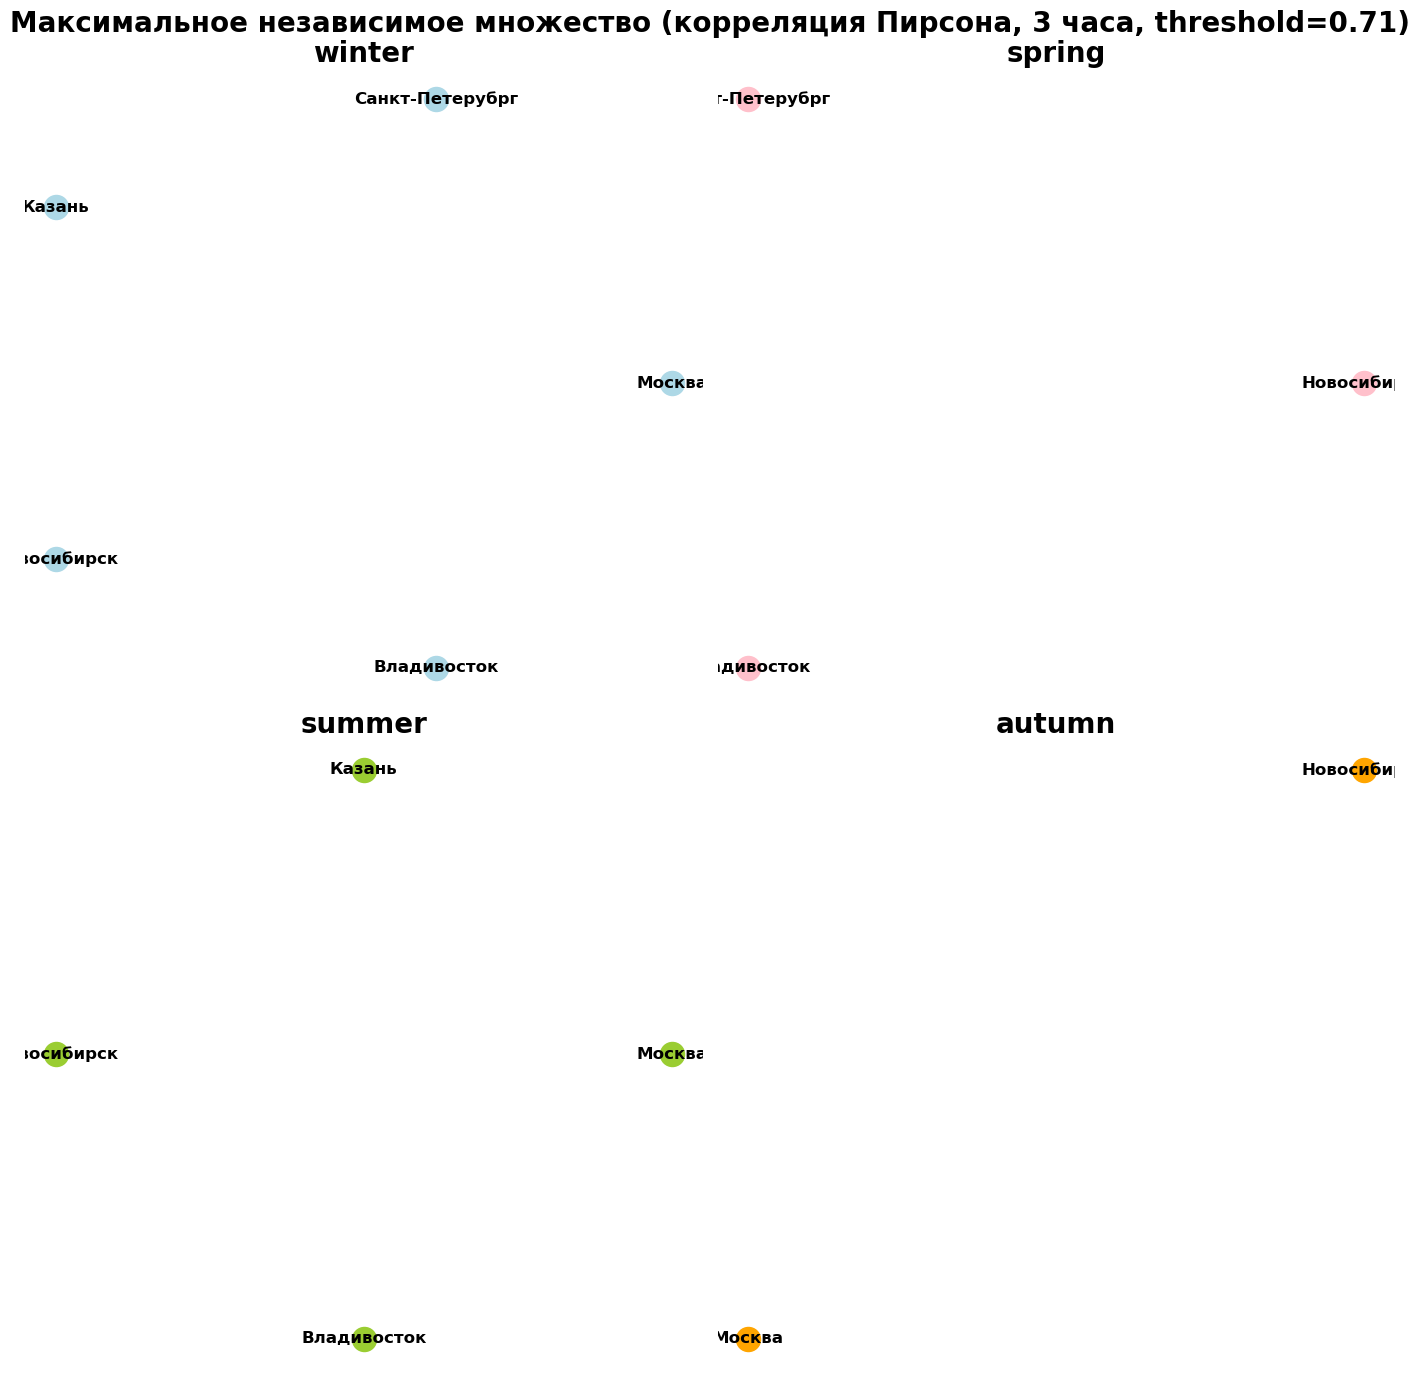

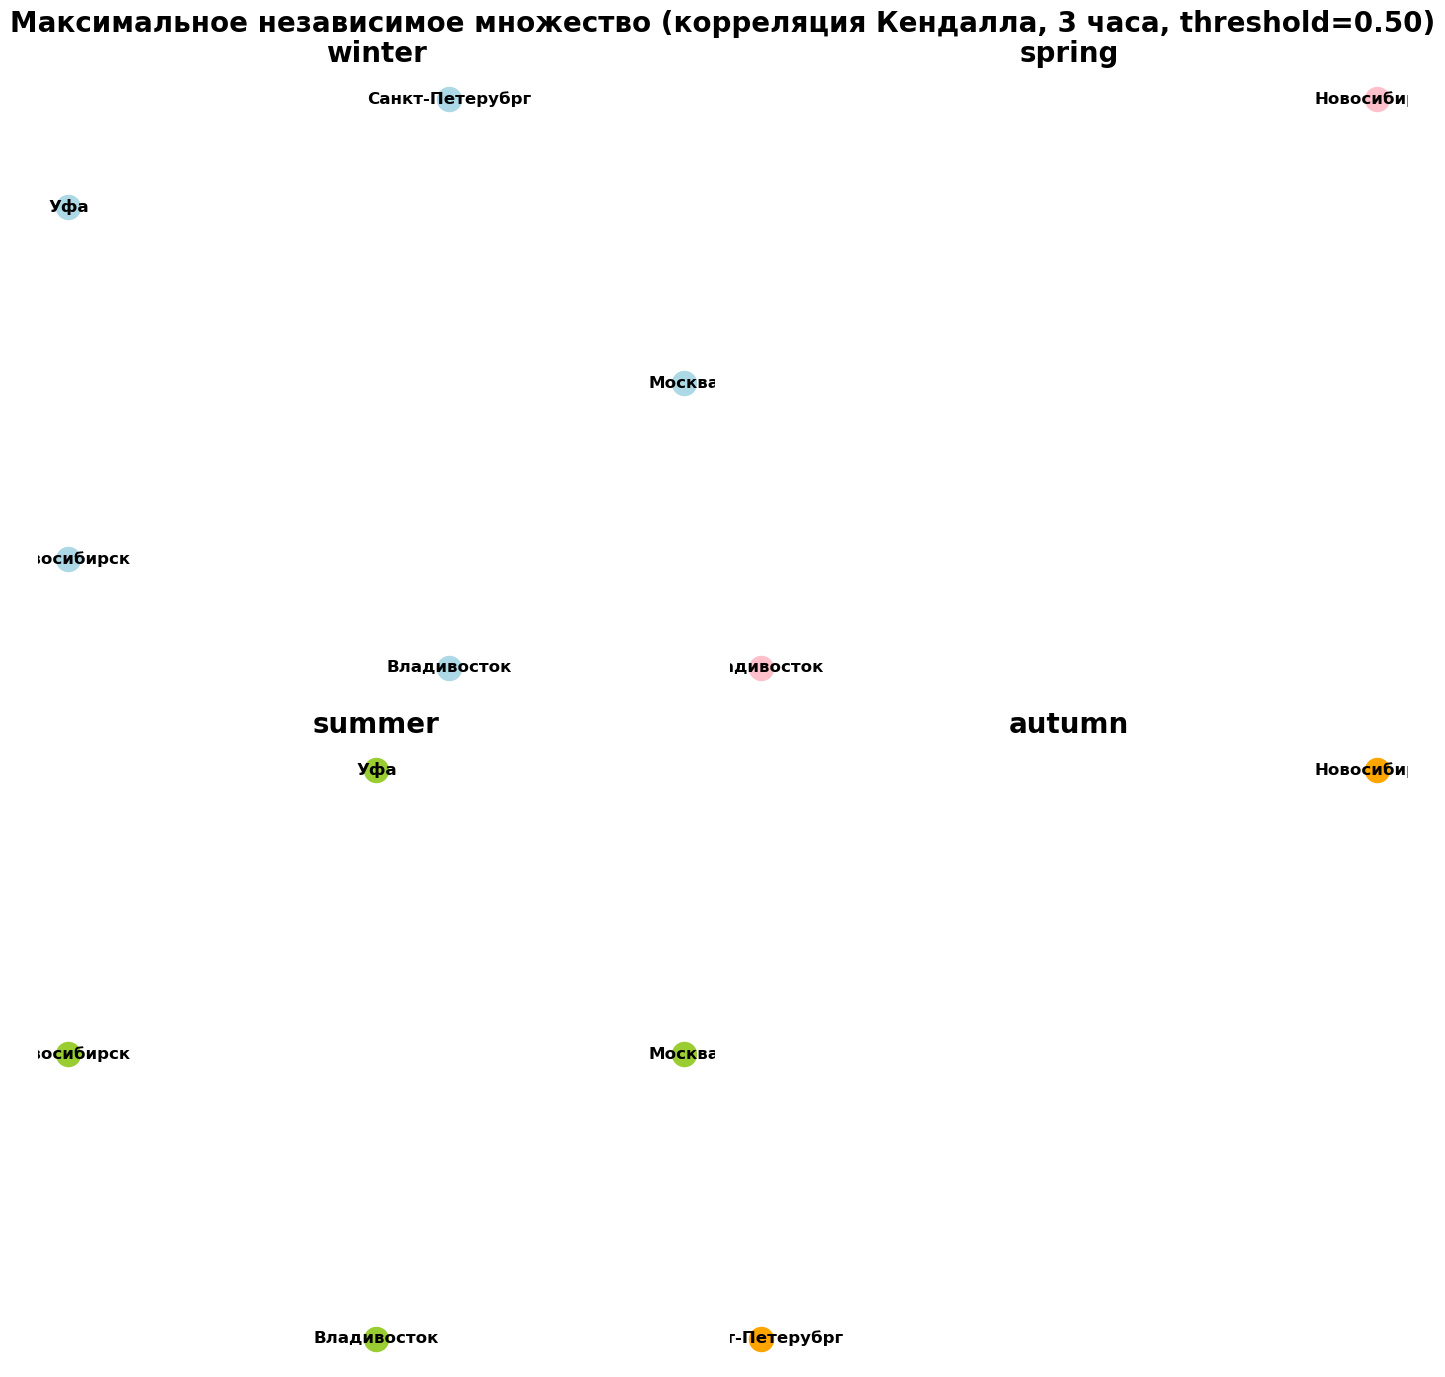

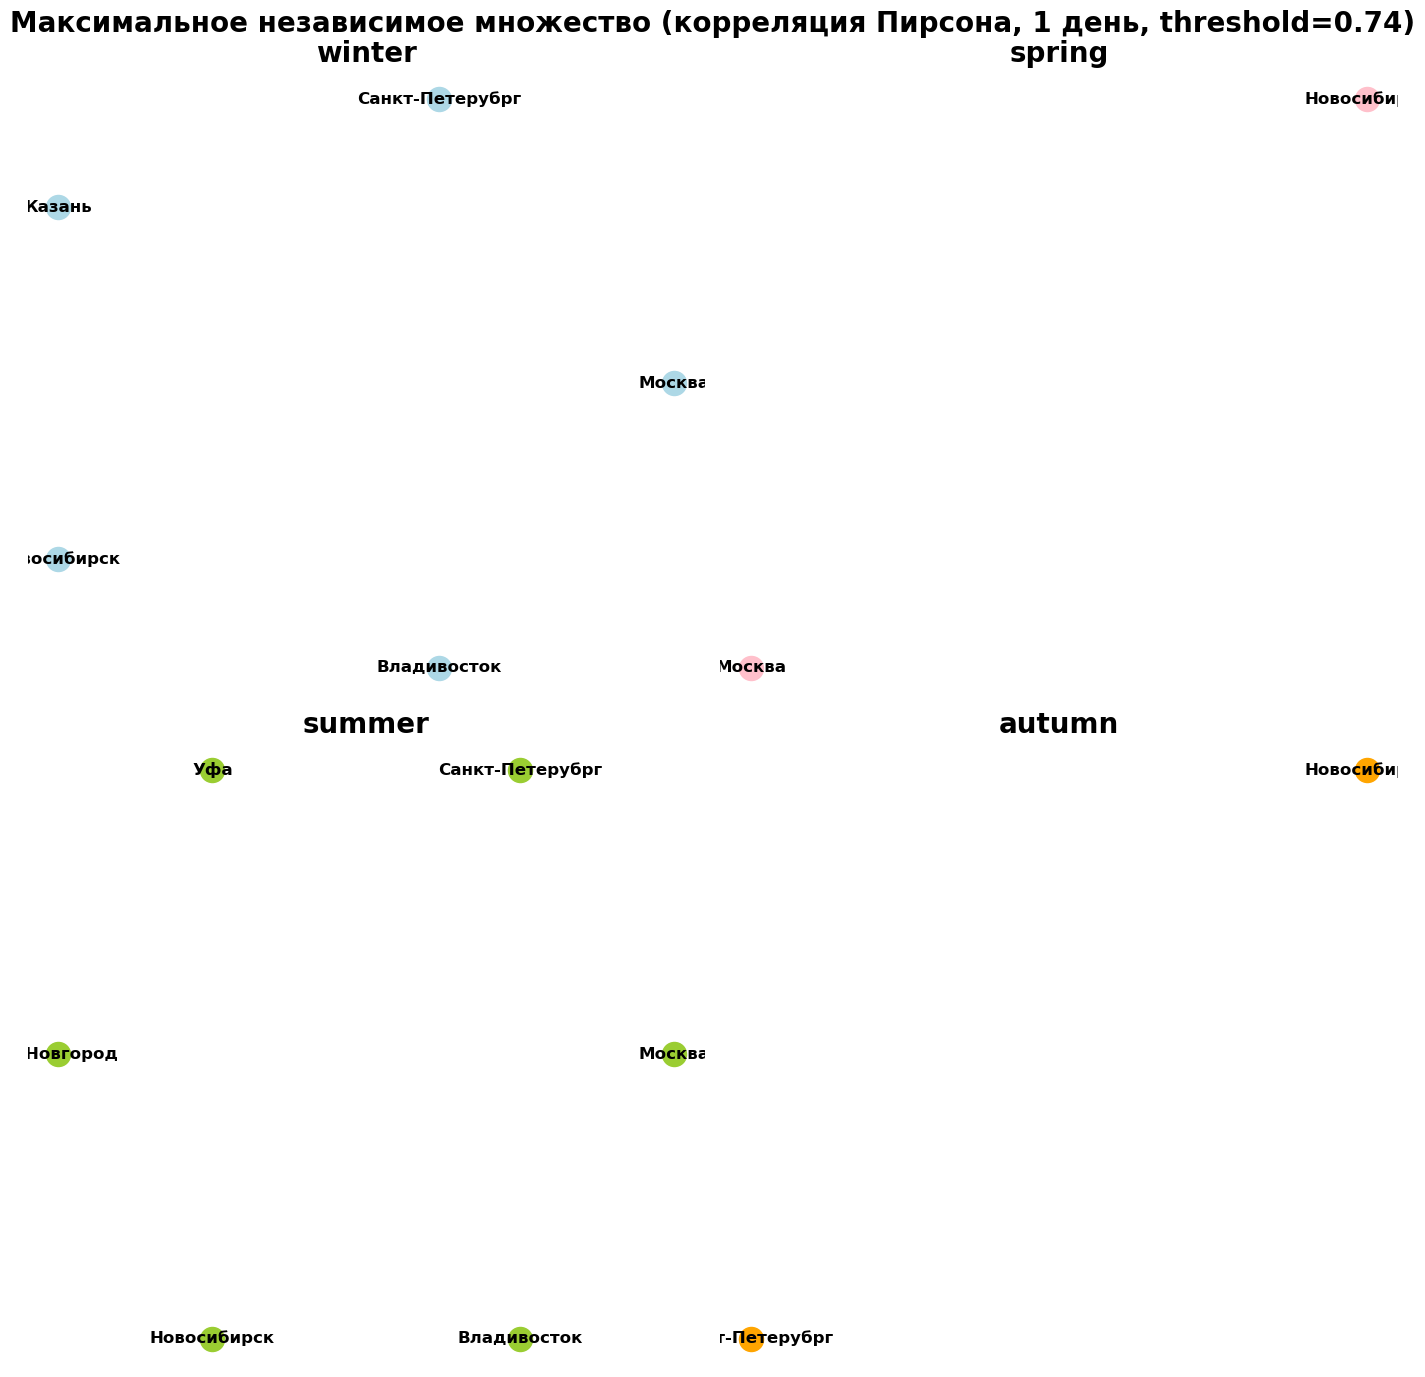

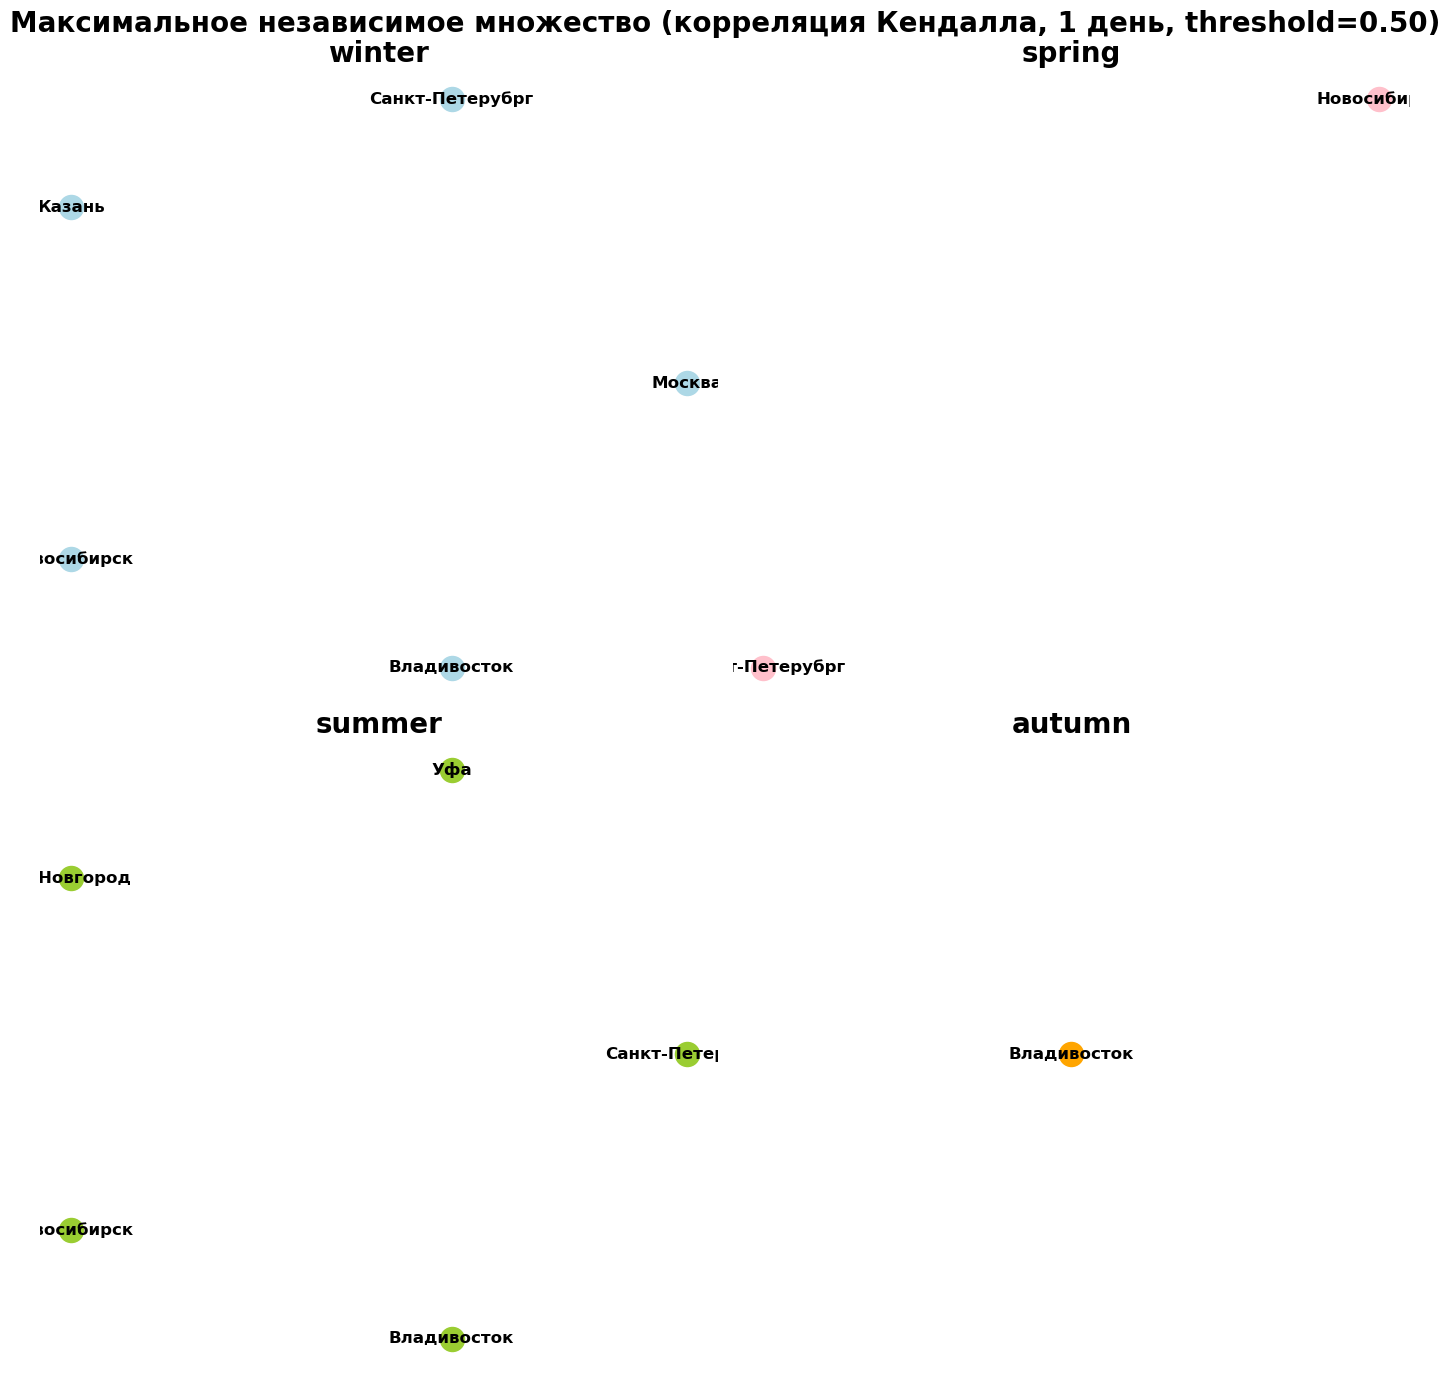

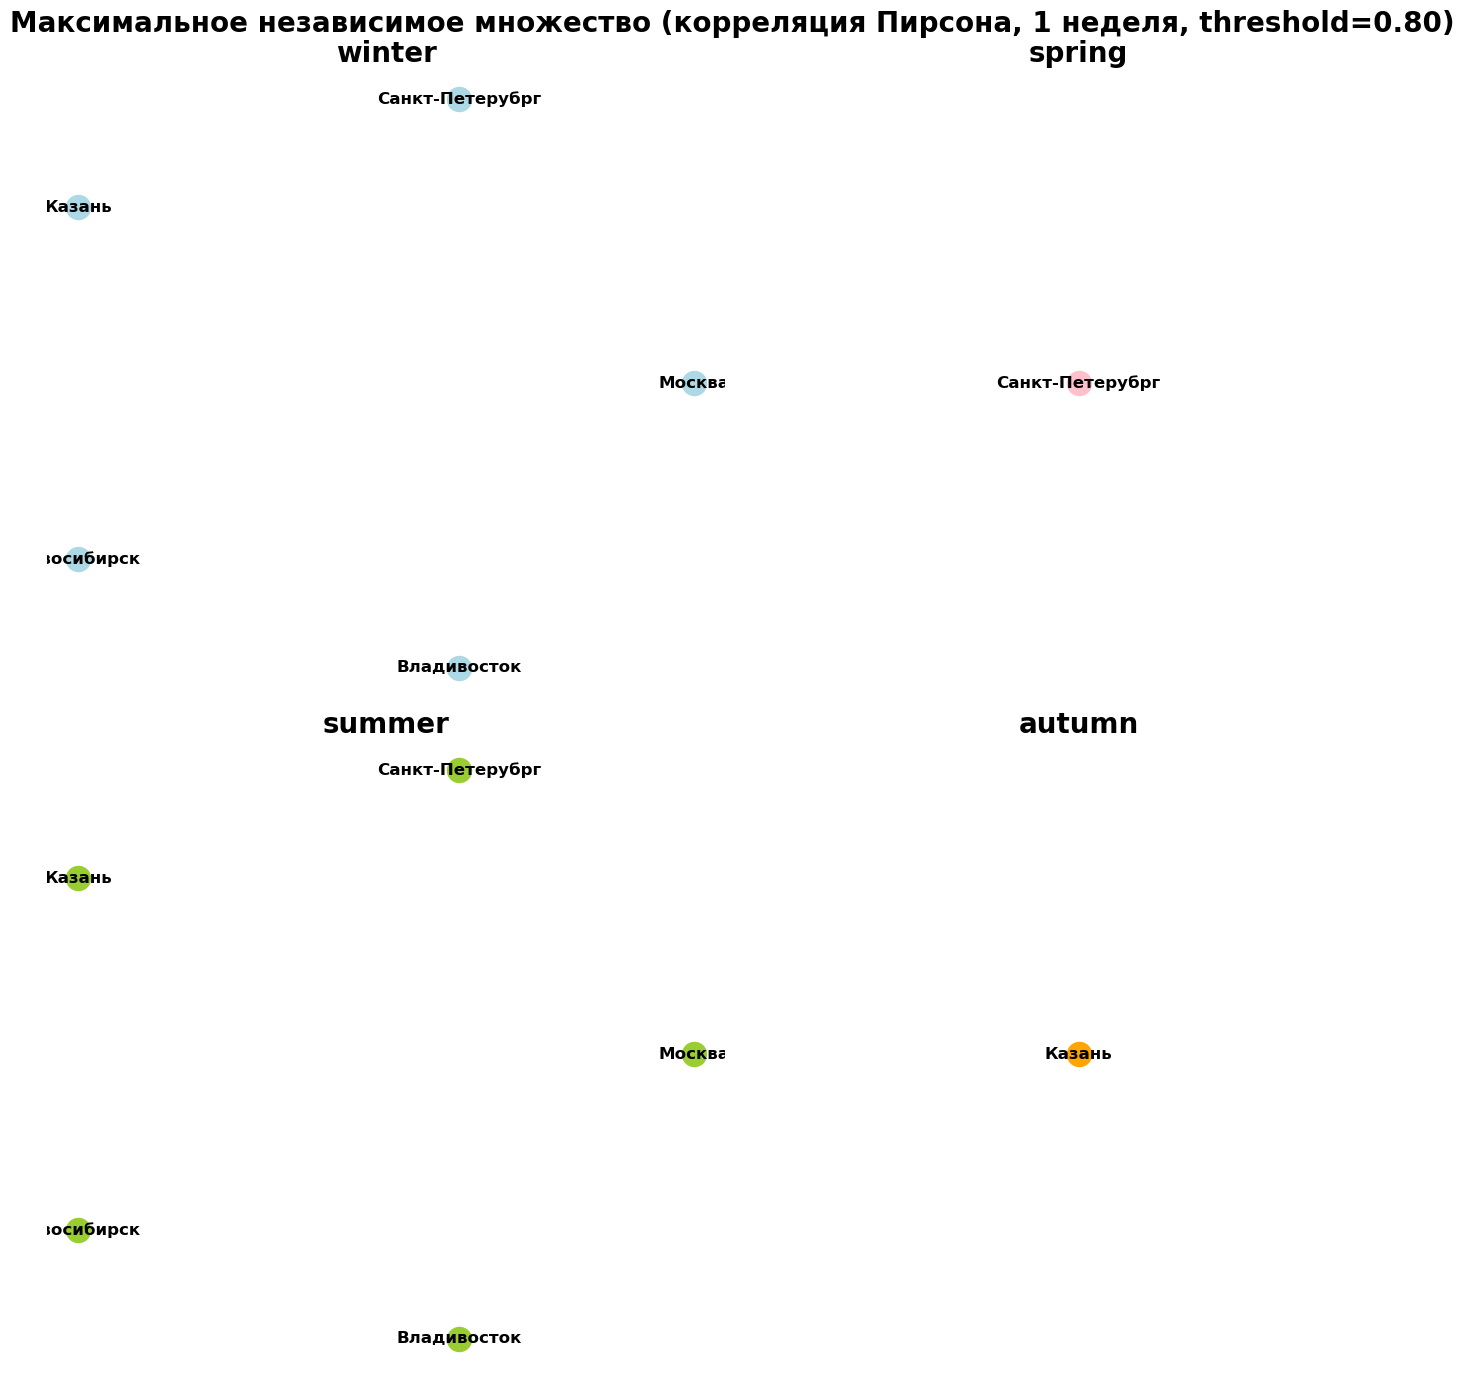

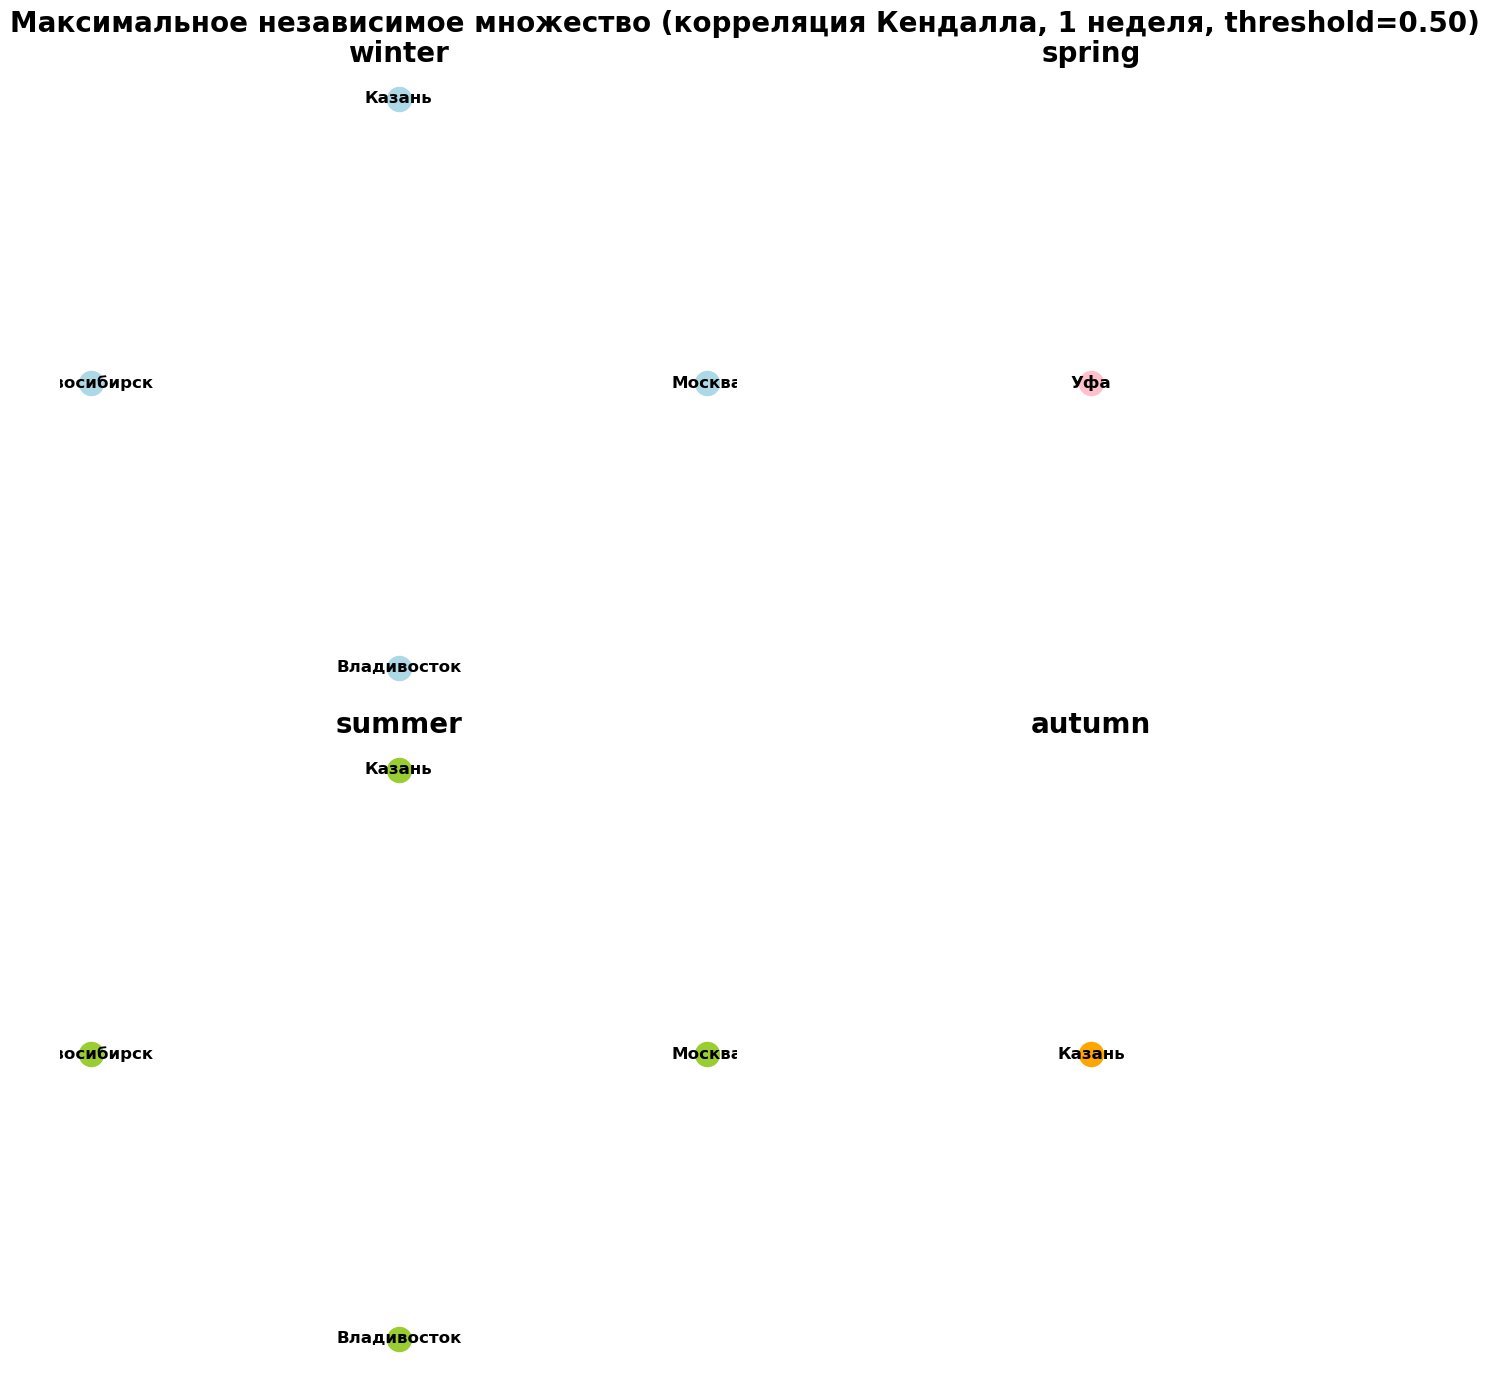

In [10]:
for interval in intervals:
    for corr_method in methods:
        draw_sets_forall_seasons_by_interval(interval, corr_method)